# Dataset 3: Mouse Cell Atlas
Batch Effect Cause: Different technology

## Importing Libraries

In [1]:
%%time

# --- General Libraries ---
import os  
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import seaborn as sns  
from typing import Dict, List, Tuple 

# --- Data Science and Bioinformatics Libraries ---
import anndata  
import scanpy as sc  
from scipy.sparse import csr_matrix  
from scipy.stats import ttest_ind  
from sklearn.preprocessing import scale  
from sklearn.metrics.pairwise import euclidean_distances  
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors

# --- Specialized Libraries ---
import pyliger  
from harmony import harmonize

# --- Custom ---
from utils import *  
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.metrics import silhouette_score as asw, adjusted_rand_score as ari
from lisi import *
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from combat.pycombat import pycombat

C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument 

CPU times: total: 7.45 s
Wall time: 1min 40s


In [2]:
%%time

def calculate_kbet(embedding, labels, k=20):
    """
    Calculate the kBET score for batch correction.

    Parameters:
    - embedding: np.array, shape (n_cells, n_dimensions), t-SNE or UMAP embedding.
    - labels: list or np.array, cell labels (e.g., batch labels).
    - k: int, the number of nearest neighbors to consider.

    Returns:
    - kBET score: float, the proportion of neighbors from the same batch.
    """
    # Fit Nearest Neighbors
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(embedding)
    
    # Find k-nearest neighbors for each cell
    neighbors = nn.kneighbors(embedding, return_distance=False)
    
    # Count how many neighbors belong to the same batch
    kbet_scores = []
    for i, cell_neighbors in enumerate(neighbors):
        # Extract batch labels of the nearest neighbors
        neighbor_labels = labels[cell_neighbors]
        # Calculate the proportion of neighbors from the same batch
        same_batch_proportion = np.sum(neighbor_labels == labels[i]) / k
        kbet_scores.append(same_batch_proportion)
    
    # kBET score: the mean proportion of neighbors from the same batch
    kbet_score = np.mean(kbet_scores)
    return kbet_score

def calculate_asw(data, embeddings_columns, labels_column):
    """
    Calculate Average Silhouette Width (ASW).
    
    Parameters:
        data (pd.DataFrame): DataFrame containing embeddings and labels.
        embeddings_columns (list): List of columns for the embedding coordinates.
        labels_column (str): Column name for the labels (e.g., 'Cluster' or 'Dataset').
    
    Returns:
        float: ASW score.
    """
    embeddings = data[embeddings_columns].values  # Get the embedding coordinates
    labels = data[labels_column].values  # Get the labels
    asw_score = silhouette_score(embeddings, labels)  # Calculate silhouette score
    return asw_score

CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
def compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw):
    """
    Computes and prints various metrics for a given embedding and metadata.

    Parameters:
    embedding (pd.DataFrame): DataFrame containing embedding coordinates.
    metadata (pd.DataFrame): DataFrame containing metadata (e.g., batch, cell type).
    compute_lisi (function): Function to compute LISI scores.
    calculate_kbet (function): Function to calculate kBET scores.
    calculate_asw (function): Function to calculate ASW scores.

    Returns:
    None
    """
    import time

    start_time = time.time()

    # Convert to a DataFrame for alignment with metadata
    embedding_df = pd.DataFrame(embedding, index=metadata.index, columns=['UMAP1', 'UMAP2'])

    # Ensure metadata categories
    metadata['batch'] = metadata['batch'].astype('category')
    metadata['CellType'] = metadata['CellType'].astype('category')

    # Compute LISI scores
    label_colnames = ["batch", "CellType"]
    lisi_scores = compute_lisi(
        X=embedding[["tsne1", "tsne2"]].values,
        metadata=metadata,
        label_colnames=label_colnames,
        perplexity=30
    )

    # Separate LISI scores
    lisi_batch = lisi_scores[:, 0]  # LISI scores for "batch"
    lisi_celltype = lisi_scores[:, 1]  # LISI scores for "celltype"

    # Print LISI results
    print("Batch Mean LISI Scores:", lisi_batch.mean())
    print("Batch Median LISI Scores:", np.median(lisi_batch))
    print("Celltype Mean LISI Scores:", lisi_celltype.mean())
    print("Celltype Median LISI Scores:", np.median(lisi_celltype))

    # Compute kBET score
    kbet_score = calculate_kbet(embedding[["tsne1", "tsne2"]].values, metadata['batch'].values, k=20)
    print(f"kBET score 20: {kbet_score}")
    
    # Compute kBET score
    kbet_score = calculate_kbet(embedding[["tsne1", "tsne2"]].values, metadata['batch'].values, k=30)
    print(f"kBET score 30: {kbet_score}")

    # Compute kBET score
    kbet_score = calculate_kbet(embedding[["tsne1", "tsne2"]].values, metadata['batch'].values, k=40)
    print(f"kBET score 40: {kbet_score}")

    # Compute ASW scores
    embedding_columns = ['tsne1', 'tsne2']
    embedding_df['CellType'] = metadata['CellType'].astype('category')
    embedding['CellType'] = embedding_df.reset_index()['CellType']
    
    # Calculate ASW for CellType
    asw_celltype = calculate_asw(embedding, embeddings_columns=embedding_columns, labels_column='CellType')
    print(f"ASW (CellType): {asw_celltype}")

    # Calculate ASW for batches (datasets)
    asw_batch = calculate_asw(embedding, embeddings_columns=embedding_columns, labels_column='Dataset')
    print(f"ASW (Batch): {asw_batch}")

    end_time = time.time()
    print(f"Execution Time: {end_time - start_time} seconds")

## Importing Dataset

In [4]:
%%time

# Directories
read_dir = r"C:/Users/namra/Emlyon/30 Master's Thesis/data/dataset_mouse_cell_atlas/"

# Filenames
expr_filename = 'filtered_total_batch1_seqwell_batch2_10x.txt'
metadata_filename = 'filtered_total_sample_ext_organ_celltype_batch.txt'

# Import datasets with error handling
metadata, expr_mat = import_datasets(read_dir, expr_filename, metadata_filename)

Expression Matrix Shape: (15006, 6954)
Metadata Shape: (6954, 10)

Missing Values:
Expression Matrix Missing Values:
T-cell_Thymus_1.GCGTCCGGTACACCGCTA    0
T-cell_Thymus_2.CGAGTATAGTCGGTCGGT    0
T-cell_Thymus_1.TGAAGCTCAAAGCGCTTG    0
T-cell_Thymus_1.TTAACTTATTGTGTATAC    0
T-cell_Thymus_1.GACACTATTCCACAAAGT    0
                                     ..
Stromal_N15.MAA001867.3_39_F.1.1      0
Stromal_M7.MAA001867.3_39_F.1.1       0
Stromal_J17.MAA001867.3_39_F.1.1      0
Stromal_M10.MAA001867.3_39_F.1.1      0
Stromal_L5.MAA001867.3_39_F.1.1       0
Length: 6954, dtype: int64

Metadata Missing Values:
nGene           0
nUMI            0
orig.ident      0
batch           0
CellType        0
ct.orig         0
tissue          0
organ           0
percent.mito    0
batchlb         0
dtype: int64
CPU times: total: 5.95 s
Wall time: 8.44 s


In [24]:
%%time

print("\nCell Type Distribution:")
display(metadata['CellType'].value_counts())
    
print("\nBatch Distribution:")
display(metadata['batch'].value_counts())


Cell Type Distribution:


CellType
T-cell           1421
Endothelial      1134
B-cell           1106
Stromal          1032
Monocyte          480
Macrophage        469
Neutrophil        454
Epithelial        390
Dendritic         220
Smooth-muscle     163
NK                 85
Name: count, dtype: int64


Batch Distribution:


batch
1    4239
2    2715
Name: count, dtype: int64

CPU times: total: 0 ns
Wall time: 5.11 ms


In [25]:
%%time

# Check the resulting expression matrix and metadata
display(expr_mat.head())
display(metadata.head())

T-cell_Thymus_1.GCGTCCGGTACACCGCTA  \
0610005C13Rik                                   0   
0610007N19Rik                                   0   
0610007P14Rik                                   0   
0610009B22Rik                                   0   
0610009D07Rik                                   0   

               T-cell_Thymus_2.CGAGTATAGTCGGTCGGT  \
0610005C13Rik                                   0   
0610007N19Rik                                   0   
0610007P14Rik                                   1   
0610009B22Rik                                   0   
0610009D07Rik                                   0   

               T-cell_Thymus_1.TGAAGCTCAAAGCGCTTG  \
0610005C13Rik                                   0   
0610007N19Rik                                   0   
0610007P14Rik                                   1   
0610009B22Rik                                   0   
0610009D07Rik                                   0   

               T-cell_Thymus_1.TTAACTTATTGTGTATAC  \
0610005C13Rik                                   0   
0610007N19Rik                                   0   
0610007P14Rik                                   0   
0610009B22Rik                                   0   
0610009D07Rik                                   0   

               T-cell_Thymus_1.GACACTATTCCACAAAGT  \
0610005C13Rik                                   0   
0610007N19Rik                                   0   
0610007P14Rik                                   0   
0610009B22Rik                                   0   
0610009D07Rik                                   0   

               T-cell_Thymus_1.ATTCCAGGTACATTCATA  \
0610005C13Rik                                   0   
0610007N19Rik                                   0   
0610007P14Rik                                   0   
0610009B22Rik                                   0   
0610009D07Rik                                   0   

               T-cell_Thymus_2.CGGCAGCCGCTAAACCTA  \
0610005C13Rik                                   0   
0610007N19Rik                                   0   
0610007P14Rik                                   0   
0610009B22Rik                                   0   
0610009D07Rik                                   0   

               T-cell_Thymus_1.AGCGAGCGGCAGAAGCGG  \
0610005C13Rik                                   0   
0610007N19Rik                                   0   
0610007P14Rik                                   0   
0610009B22Rik                                   0   
0610009D07Rik                                   0   

               T-cell_Thymus_1.CGTATTCAACAAGTCCCG  \
0610005C13Rik                                   0   
0610007N19Rik                                   0   
0610007P14Rik                                   0   
0610009B22Rik                                   0   
0610009D07Rik                                   0   

               T-cell_Thymus_1.ACACCCCGAGTACGCACC  ...  \
0610005C13Rik                                   0  ...   
0610007N19Rik                                   0  ...   
0610007P14Rik                                   0  ...   
0610009B22Rik                                   0  ...   
0610009D07Rik                                   0  ...   

               Epithelial_K16.MAA001867.3_39_F.1.1  \
0610005C13Rik                                    0   
0610007N19Rik                                  228   
0610007P14Rik                                   31   
0610009B22Rik                                    0   
0610009D07Rik                                  157   

               Epithelial_N8.MAA001867.3_39_F.1.1  \
0610005C13Rik                                   0   
0610007N19Rik                                   0   
0610007P14Rik                                   0   
0610009B22Rik                                   0   
0610009D07Rik                                   0   

               Stromal_N9.MAA001867.3_39_F.1.1  \
0610005C13Rik                                0   
0610007N19Rik                               35   
0

nGene  nUMI orig.ident  batch CellType  \
T-cell_Thymus_1.GCGTCCGGTACACCGCTA    525   672     T-cell      1   T-cell   
T-cell_Thymus_2.CGAGTATAGTCGGTCGGT    885  1859     T-cell      1   T-cell   
T-cell_Thymus_1.TGAAGCTCAAAGCGCTTG   2199  5379     T-cell      1   T-cell   
T-cell_Thymus_1.TTAACTTATTGTGTATAC   1503  3046     T-cell      1   T-cell   
T-cell_Thymus_1.GACACTATTCCACAAAGT   1064  1535     T-cell      1   T-cell   

                                   ct.orig  tissue   organ  percent.mito  \
T-cell_Thymus_1.GCGTCCGGTACACCGCTA  T_cell  Thymus  Immune             0   
T-cell_Thymus_2.CGAGTATAGTCGGTCGGT  T_cell  Thymus  Immune             0   
T-cell_Thymus_1.TGAAGCTCAAAGCGCTTG  T_cell  Thymus  Immune             0   
T-cell_Thymus_1.TTAACTTATTGTGTATAC  T_cell  Thymus  Immune             0   
T-cell_Thymus_1.GACACTATTCCACAAAGT  T_cell  Thymus  Immune             0   

                                   batchlb  
T-cell_Thymus_1.GCGTCCGGTACACCGCTA  Batch1  
T-cell_Thymus_2.CGAGTATAGTCGGTCGGT  Batch1  
T-cell_Thymus_1.TGAAGCTCAAAGCGCTTG  Batch1  
T-cell_Thymus_1.TTAACTTATTGTGTATAC  Batch1  
T-cell_Thymus_1.GACACTATTCCACAAAGT  Batch1

CPU times: total: 0 ns
Wall time: 10.1 ms


nGene: Number of genes detected as expressed in each cell. 

nUMI: Number of unique molecular identifiers detected in a cell. Cells with low nUMI counts may be filtered out because they might not contain enough biological information for meaningful analysis. On the other hand, cells with excessively high nUMI counts could represent doublets (two cells mistakenly captured together).

orig.ident: Original identity or labels of the sample from which the cells were derived 



## Exploratory Data Analysis

<timed exec>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



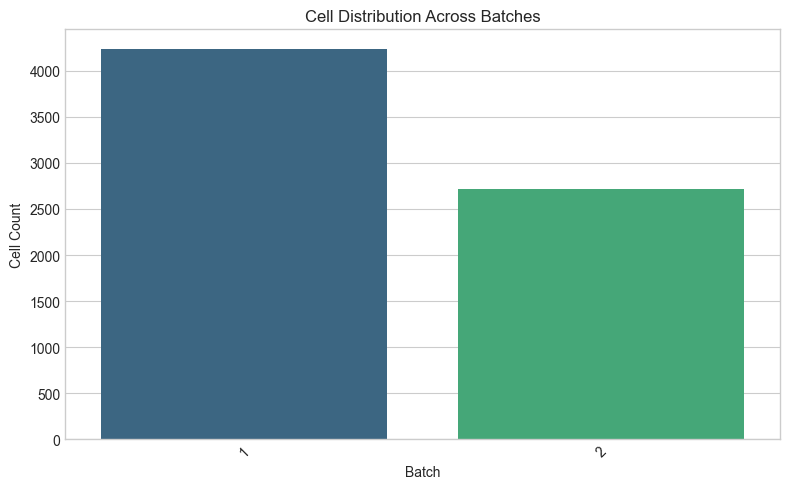

CPU times: total: 15.6 ms
Wall time: 269 ms


In [73]:
%%time

# EDA: Distribution of cells per batch
plt.figure(figsize=(8, 5))
sns.countplot(data=metadata, x='batch', palette="viridis")
plt.title("Cell Distribution Across Batches")
plt.xlabel("Batch")
plt.ylabel("Cell Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

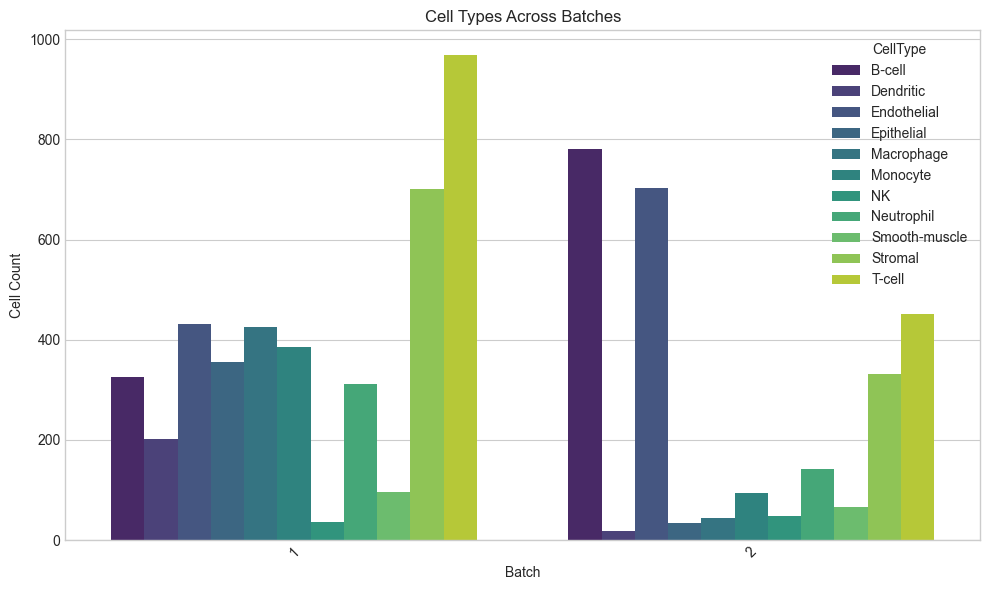

CPU times: total: 62.5 ms
Wall time: 358 ms


In [70]:
%%time

# EDA: Cell types per batch
plt.figure(figsize=(10, 6))
sns.countplot(data=metadata, x='batch', hue='CellType', palette="viridis")
plt.title("Cell Types Across Batches")
plt.xlabel("Batch")
plt.ylabel("Cell Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

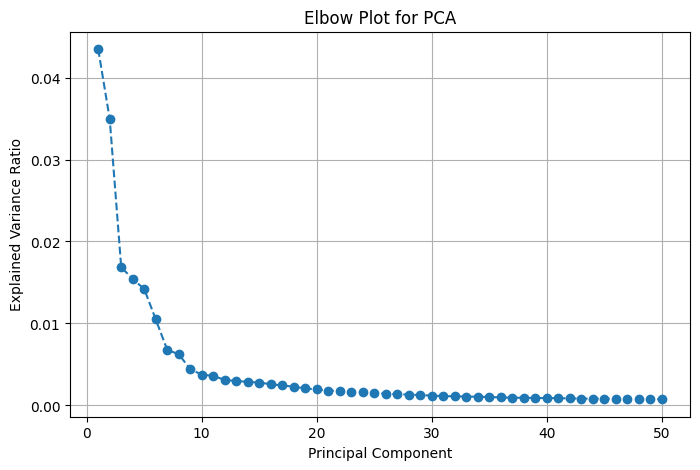

In [5]:
# Create AnnData object
adata = sc.AnnData(X=expr_mat.T, obs=metadata)

# Normalize and log transform data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Compute PCA with more components to check explained variance
sc.tl.pca(adata, svd_solver='arpack')

# Plot the explained variance ratio
explained_variance_ratio = adata.uns['pca']['variance_ratio']

# Elbow plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Plot for PCA')
plt.grid(True)
plt.show()

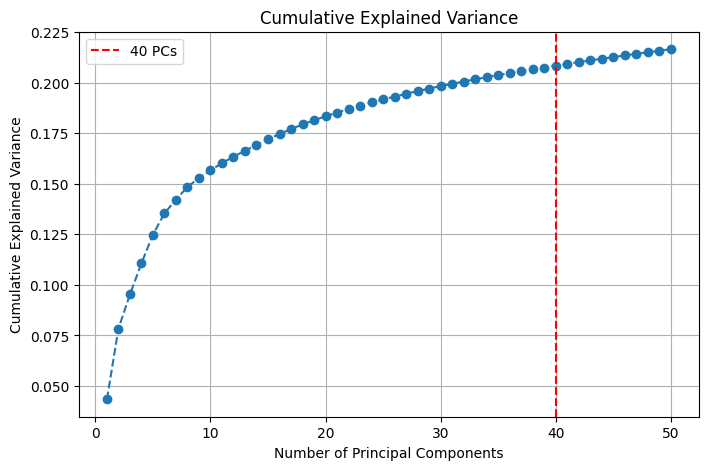

Variance explained by first 50 PCs: 21.65%
Variance explained by first 40 PCs: 20.84%
Variance explained by first 30 PCs: 19.83%
Variance explained by first 20 PCs: 18.33%
Variance explained by first 10 PCs: 15.66%


In [7]:
# Cumulative explained variance
cumulative_variance = np.cumsum(adata.uns['pca']['variance_ratio'])

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axvline(40, color='r', linestyle='--', label='40 PCs')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.savefig("cumulative_variance_plot.png")
plt.show()

# Print explained variance captured by 40 PCs
# print(f"Variance explained by first 60 PCs: {cumulative_variance[59]:.2%}")
print(f"Variance explained by first 50 PCs: {cumulative_variance[49]:.2%}")
print(f"Variance explained by first 40 PCs: {cumulative_variance[39]:.2%}")
print(f"Variance explained by first 30 PCs: {cumulative_variance[29]:.2%}")
print(f"Variance explained by first 20 PCs: {cumulative_variance[19]:.2%}")
print(f"Variance explained by first 10 PCs: {cumulative_variance[9]:.2%}")

### Batch Effects Analysis

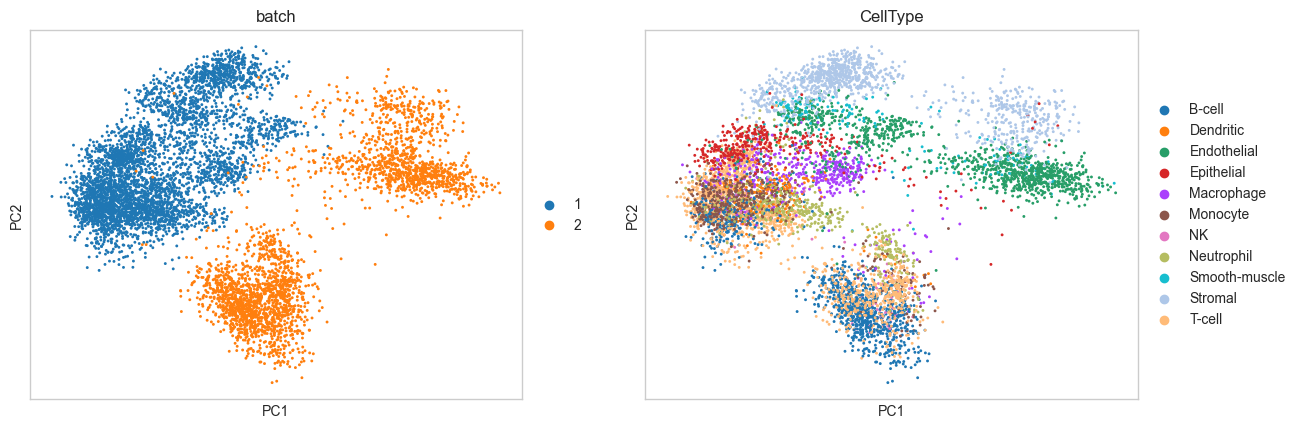

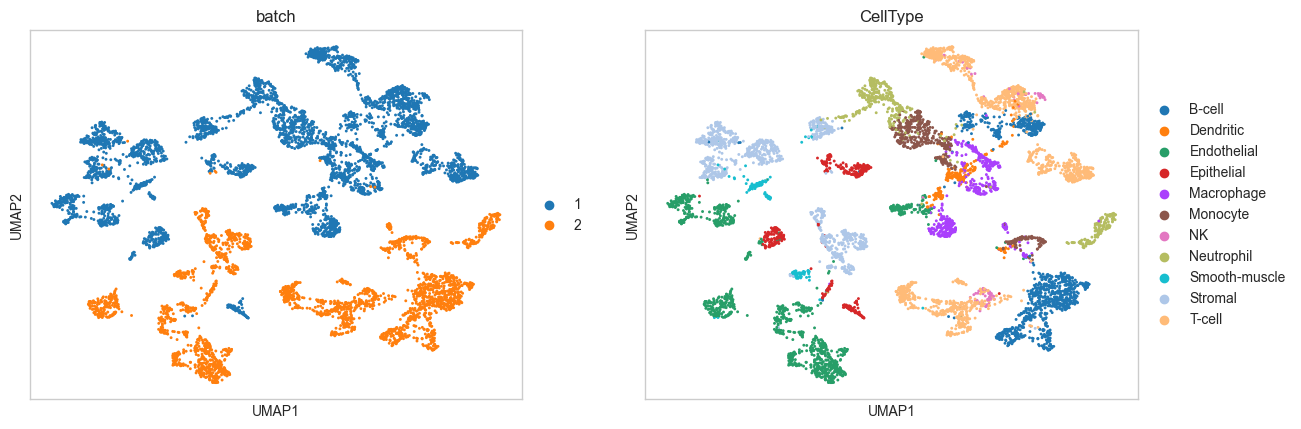

CPU times: total: 15.8 s
Wall time: 14.3 s


In [17]:
%%time

# Prepare data for scanpy AnnData
adata = sc.AnnData(X=expr_mat.T, obs=metadata)

# Normalize & log transform data 
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.obs['batch'] = adata.obs['batch'].astype('category')

# Run PCA & UMAP for batch visualization
sc.tl.pca(adata)
sc.pl.pca(adata, color=['batch', 'CellType'])

# Running UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch', 'CellType'])

In [18]:
%%time

batches = adata.obs['batch'].unique()

batch_data = {batch: adata[adata.obs['batch'] == batch].X.toarray() for batch in batches}

# Perform statistical tests (t-test) for each gene across batches
gene_pvals = []
for gene_idx in range(adata.shape[1]):  
    batch_exprs = [batch_data[batch][:, gene_idx] for batch in batches]
    if len(batch_exprs) == 2:
        # performing t test
        _, pval = ttest_ind(batch_exprs[0], batch_exprs[1], equal_var=False)
    else:
        # Perform ANOVA or other tests if >2 batches
        raise NotImplementedError("Extend for >2 batches if needed.")
    gene_pvals.append(pval)

results_df = pd.DataFrame({
    "gene": adata.var_names,  # Gene names
    "p_value": gene_pvals
})

results_df['adjusted_p_value'] = results_df['p_value'] * len(results_df)
results_df['adjusted_p_value'] = results_df['adjusted_p_value'].clip(upper=1.0)
significant_genes = results_df[results_df['adjusted_p_value'] < 0.05]
print(f"Number of significant genes: {len(significant_genes)}")
print(significant_genes)

# Batch-to-batch distance
batch_means = {batch: np.mean(batch_data[batch], axis=0) for batch in batches}
batch_distances = euclidean_distances(list(batch_means.values()))

# Print the distances
print("Batch-to-batch distances (Euclidean):")
batch_distance_df = pd.DataFrame(
    batch_distances, 
    index=batches, 
    columns=batches
)
print(batch_distance_df)

Number of significant genes: 7306
                gene        p_value  adjusted_p_value
1      0610007N19Rik   1.833010e-38      2.750615e-34
4      0610009D07Rik  1.935487e-256     2.904392e-252
7      0610010F05Rik   2.000951e-07      3.002627e-03
8      0610010K14Rik  3.429883e-144     5.146883e-140
9      0610011F06Rik   5.014690e-67      7.525044e-63
...              ...            ...               ...
14999          Zwint   7.245755e-13      1.087298e-08
15001           Zxdc   2.273572e-24      3.411722e-20
15002         Zyg11b   8.318134e-25      1.248219e-20
15004          Zzef1   1.637688e-37      2.457515e-33
15005           Zzz3   7.252851e-08      1.088363e-03

[7306 rows x 3 columns]
Batch-to-batch distances (Euclidean):
           1          2
1   0.000000  22.305603
2  22.305603   0.000000
CPU times: total: 14.4 s
Wall time: 14.9 s


A total of 7306 genes show statistically significant differences in expression between batches, as indicated by their low p-values. 

Euclidean distance of 22.305603 supports the presence of batch effects.

## LIGER
https://github.com/welch-lab/pyliger/blob/master/integrating_multi_scRNA_data.ipynb

In [5]:
%%time

batch_label='batchlb'
celltype_label='CellType' 

# Separate datasets by batch
datasets = {}
for batch in metadata[batch_label].unique():
    batch_cells = metadata[metadata[batch_label] == batch].index
    datasets[batch] = expr_mat.loc[:, batch_cells]

# Convert each batch dataset into an AnnData object
adata_list = []
for batch, dataset in datasets.items():
    # Ensure unique cell names (obs)
    cell_names = dataset.columns
    
    # Ensure unique gene names (var)
    gene_names = expr_mat.index
    
    # Create an AnnData object for each batch dataset
    adata = sc.AnnData(
        X=dataset.T,  # Transpose the dataset to have cells as rows and genes as columns
        obs=metadata.loc[dataset.columns],  # Metadata corresponding to cells
        var=pd.DataFrame(index=expr_mat.index)  # Ensure 'var' is a DataFrame with gene names
    )
    
    adata.obs.index.name = 'cell_names'
    adata.var.index.name = 'gene_names'
    
    adata.uns['sample_name'] = batch   

    adata_list.append(adata)

CPU times: total: 359 ms
Wall time: 538 ms


100%|██████████| 30/30 [02:16<00:00,  4.54s/it]
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyliger\plotting\_dataset_cluster.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


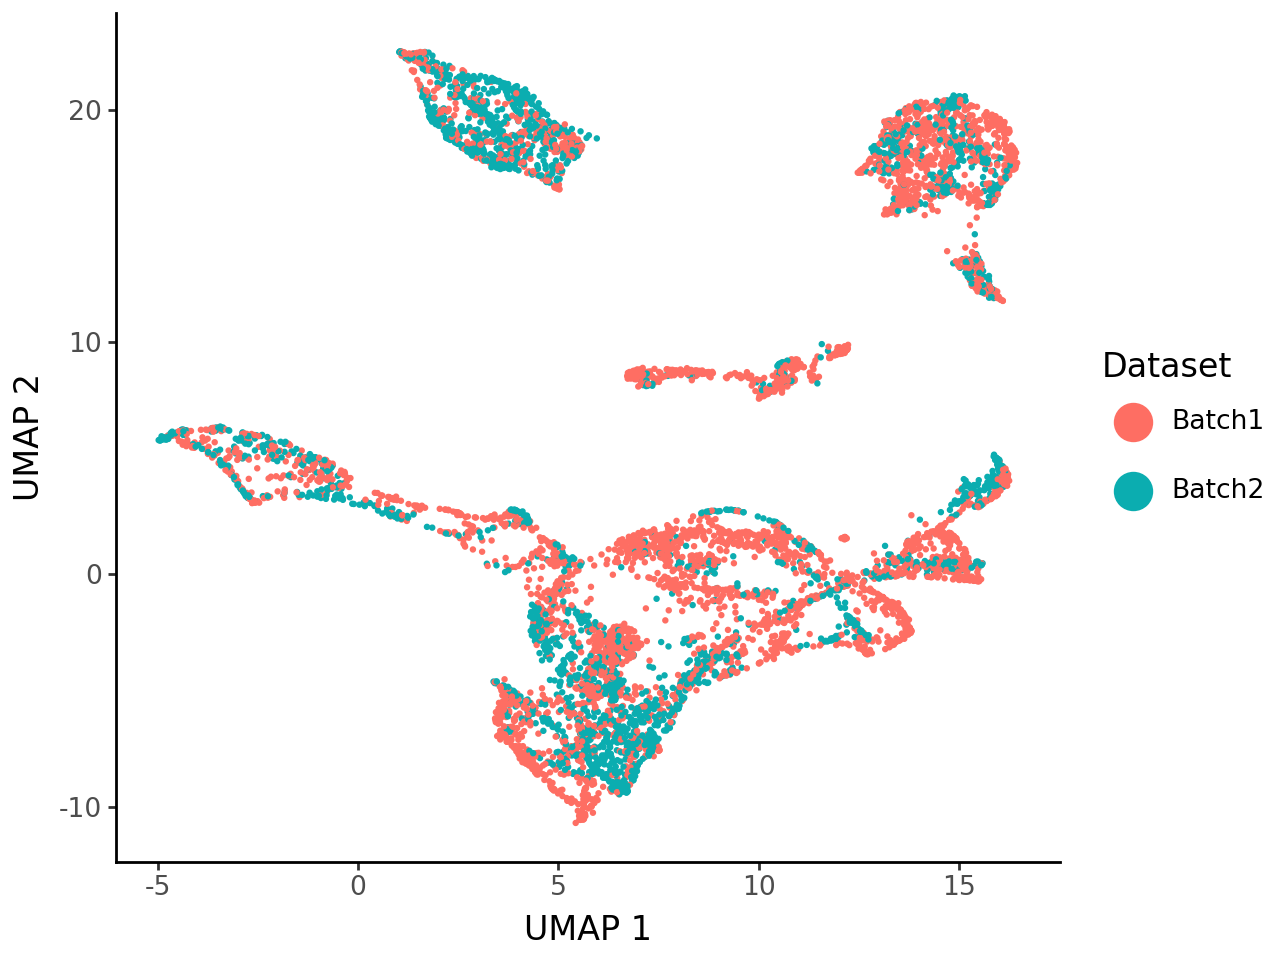

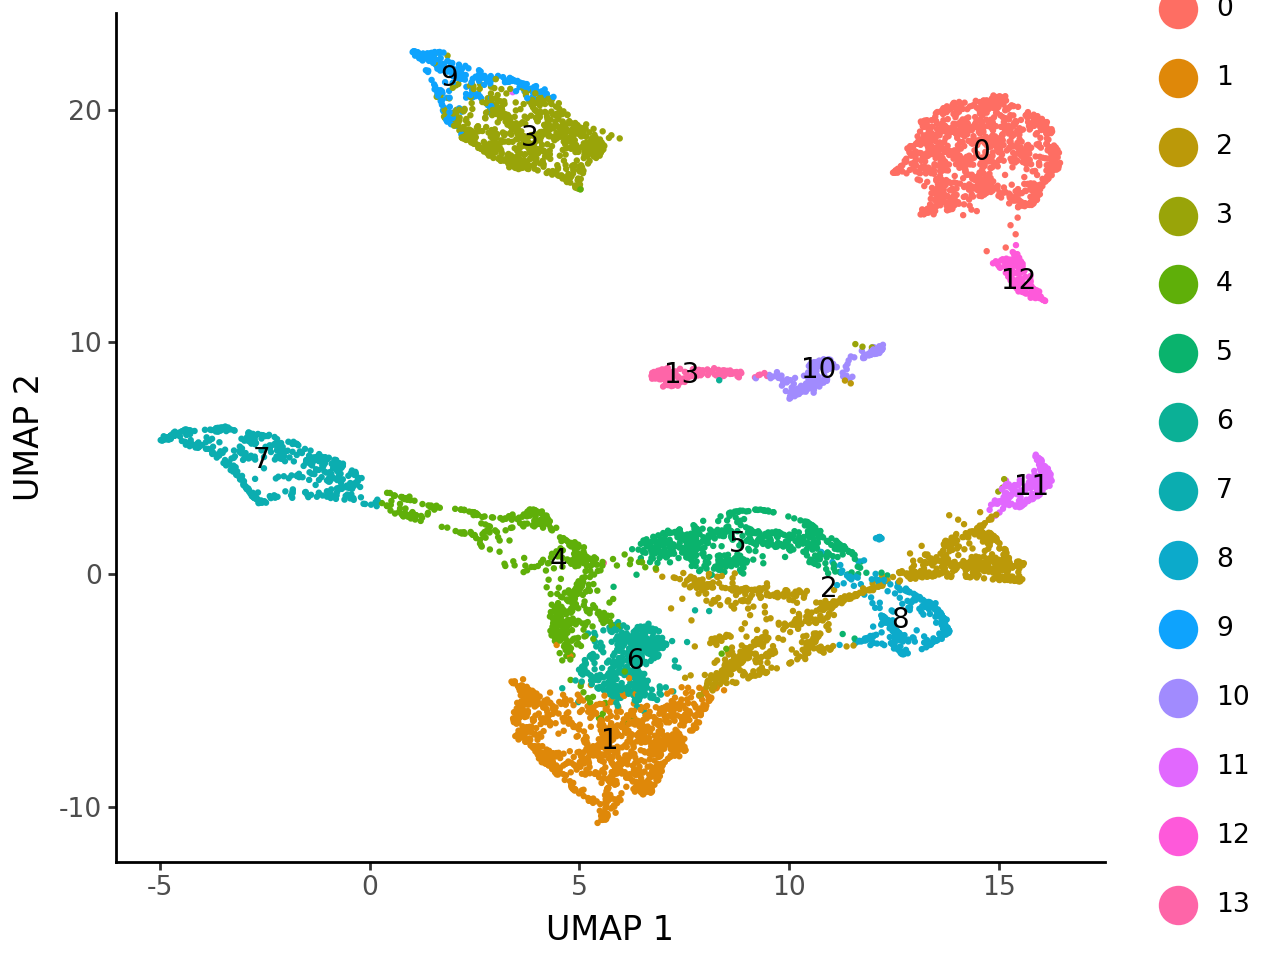

Performing Wilcoxon test on ALL datasets: Batch1, Batch2
CPU times: total: 6min 35s
Wall time: 3min 4s


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [7]:
%%time

k=11
var_thresh=0.1

try:
    # Create LIGER object from the list of AnnData objects
    liger_object = pyliger.create_liger(adata_list)
except ValueError as e:
    print(f"ValueError occurred while creating LIGER object: {e}")
    print("adata_list:", adata_list)
    raise

# Preprocessing steps (separate function calls)
pyliger.normalize(liger_object)  # Normalize the LIGER object
pyliger.select_genes(liger_object, var_thresh=var_thresh)  # Select variable genes
pyliger.scale_not_center(liger_object)  # Scale data without centering

# Factorization and alignment
pyliger.optimize_ALS(liger_object, k=k, nrep = 1)  # Perform ALS optimization

# Quantile Normalization and Clustering
pyliger.quantile_norm(liger_object)
pyliger.leiden_cluster(liger_object, resolution=0.25)

# Visualization
pyliger.run_umap(liger_object, distance='cosine', n_neighbors=40, min_dist=0.3)
embedding = liger_object.tsne_coords
plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels=['UMAP 1', 'UMAP 2'], return_plots=True)

for plot in plots:
    plt.figure(figsize=(8, 6))
    plot.show()

# Downstream Analysis
cluster_results = pyliger.run_wilcoxon(liger_object, compare_method="clusters")

In [8]:
compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw)

Batch Mean LISI Scores: 1.5286527232541576
Batch Median LISI Scores: 1.5592162325600507
Celltype Mean LISI Scores: 1.4177627017847472
Celltype Median LISI Scores: 1.1314478652716846
kBET score 20: 0.7031564567155594
kBET score 30: 0.6872351644137666
kBET score 40: 0.6774769916594766
ASW (CellType): 0.12148475646972656
ASW (Batch): 0.03804657980799675
Execution Time: 5.200051546096802 seconds


Removing 663 genes not expressing in Batch1.
Removing 19 genes not expressing in Batch2.
Index(['Amd2', 'Apoo-ps', 'Csn1s2a', 'Csn1s2b', 'Dynlt1c', 'Epx', 'Fabp6',
       'Gm12669', 'Gm14851', 'Gm15772', 'Gm5416', 'Gm5424', 'Hbb-bh1', 'Hbb-y',
       'Mia2', 'Msmp', 'Nutf2-ps1', 'Oaz1-ps', 'Rnaset2a'],
      dtype='object', name='gene_names')


100%|██████████| 30/30 [04:55<00:00,  9.86s/it]
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyliger\plotting\_dataset_cluster.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


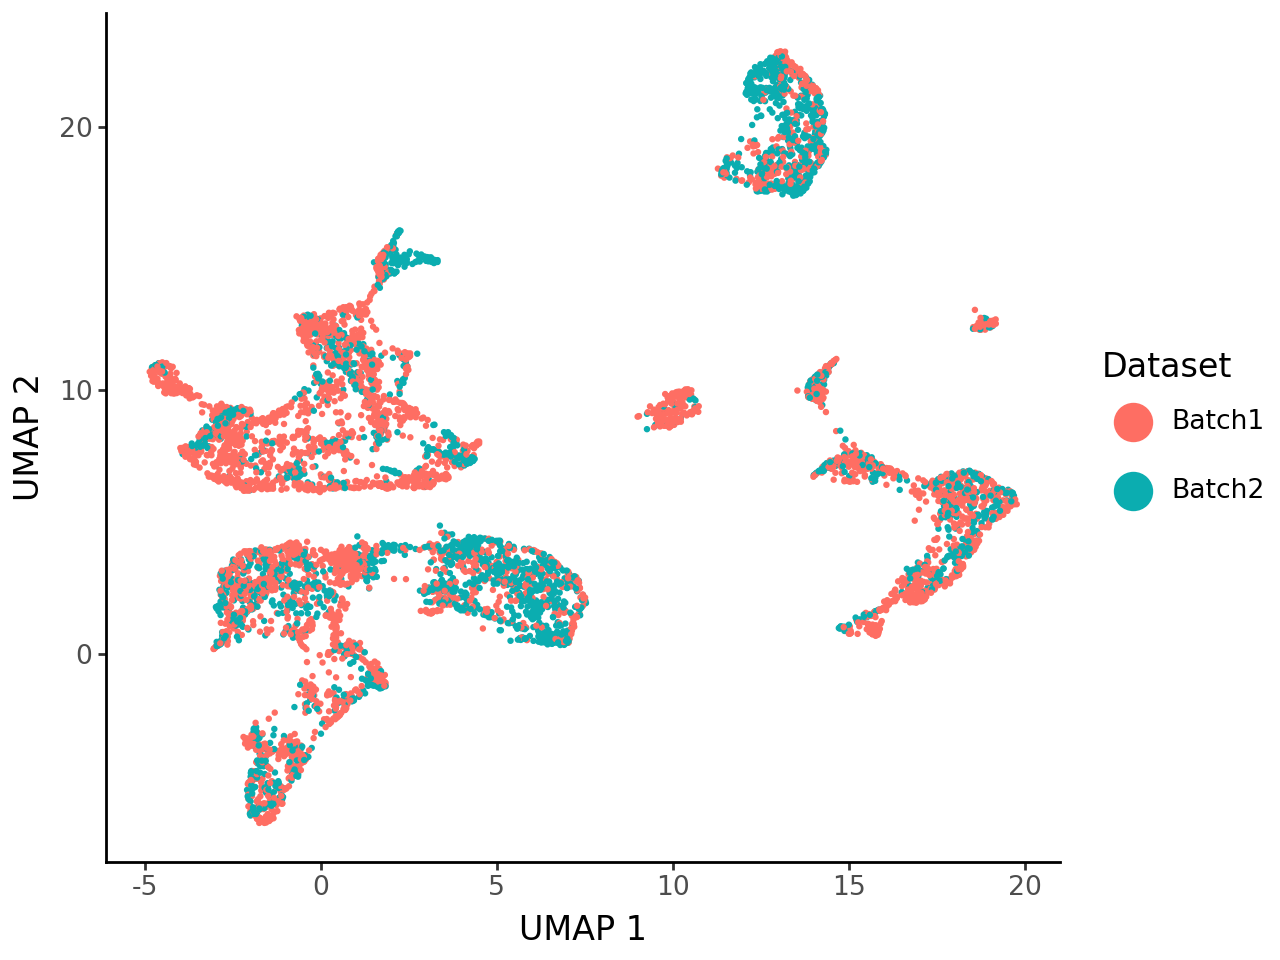

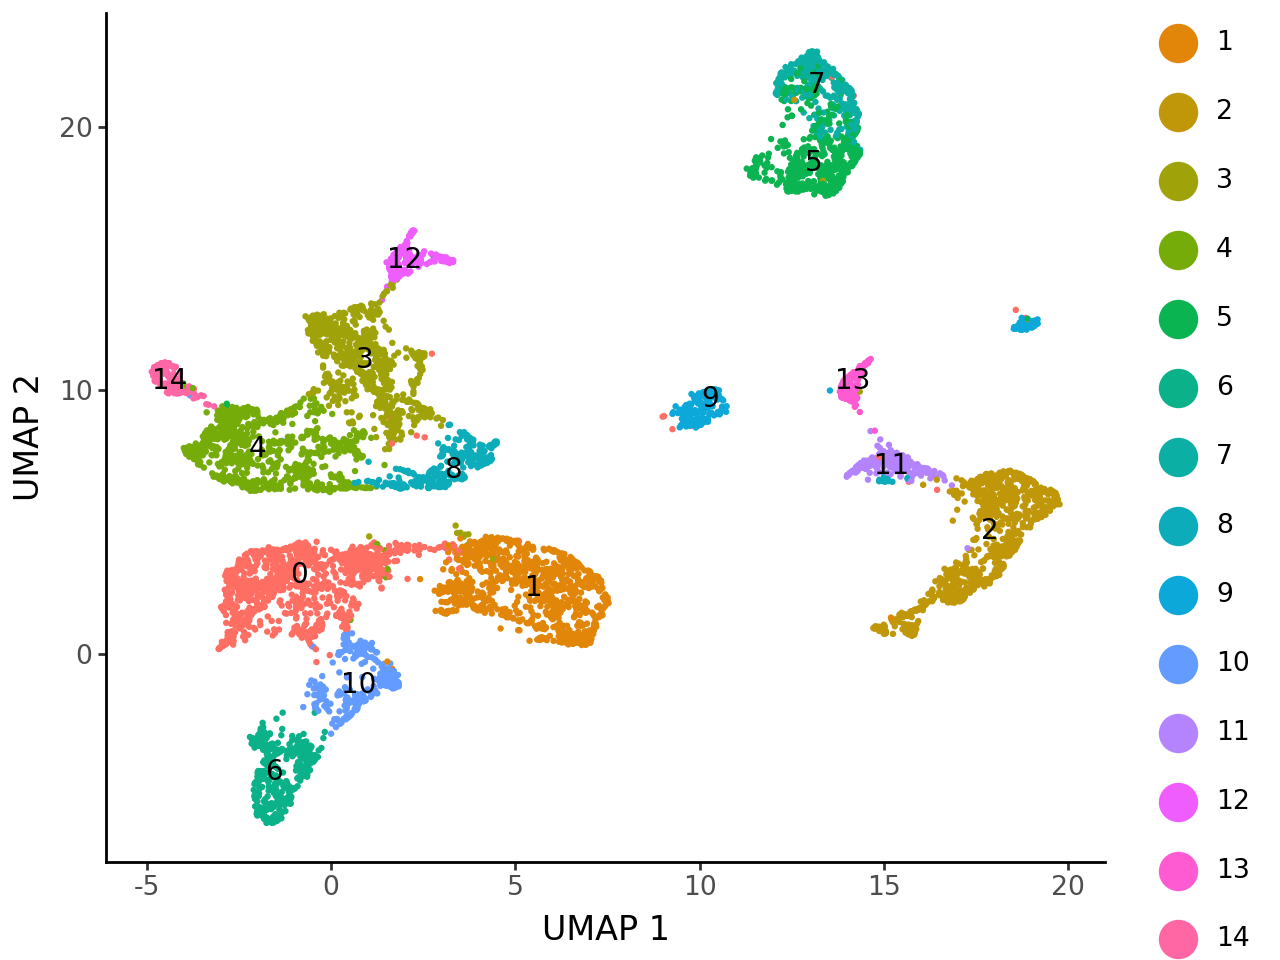

Performing Wilcoxon test on ALL datasets: Batch1, Batch2
CPU times: total: 8min 21s
Wall time: 5min 42s


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [8]:
%%time

k=20
var_thresh=0.1

try:
    # Create LIGER object from the list of AnnData objects
    liger_object = pyliger.create_liger(adata_list)
except ValueError as e:
    print(f"ValueError occurred while creating LIGER object: {e}")
    print("adata_list:", adata_list)
    raise

# Preprocessing steps (separate function calls)
pyliger.normalize(liger_object)  # Normalize the LIGER object
pyliger.select_genes(liger_object, var_thresh=var_thresh)  # Select variable genes
pyliger.scale_not_center(liger_object)  # Scale data without centering

# Factorization and alignment
pyliger.optimize_ALS(liger_object, k=k, nrep = 1)  # Perform ALS optimization

# Quantile Normalization and Clustering
pyliger.quantile_norm(liger_object)
pyliger.leiden_cluster(liger_object, resolution=0.25)

# Visualization
pyliger.run_umap(liger_object, distance='cosine', n_neighbors=40, min_dist=0.3)
embedding = liger_object.tsne_coords
plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels=['UMAP 1', 'UMAP 2'], return_plots=True)

for plot in plots:
    plt.figure(figsize=(8, 6))
    plot.show()

# Downstream Analysis
cluster_results = pyliger.run_wilcoxon(liger_object, compare_method="clusters")

In [13]:
compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw)

Batch Mean LISI Scores: 1.5665148401186768
Batch Median LISI Scores: 1.6024287181546941
Celltype Mean LISI Scores: 1.3199464364480056
Celltype Median LISI Scores: 1.0525280876532865
kBET score: 0.6815358067299395
ASW (CellType): 0.1296955794095993
ASW (Batch): 0.028652753680944443
Execution Time: 4.362009286880493 seconds


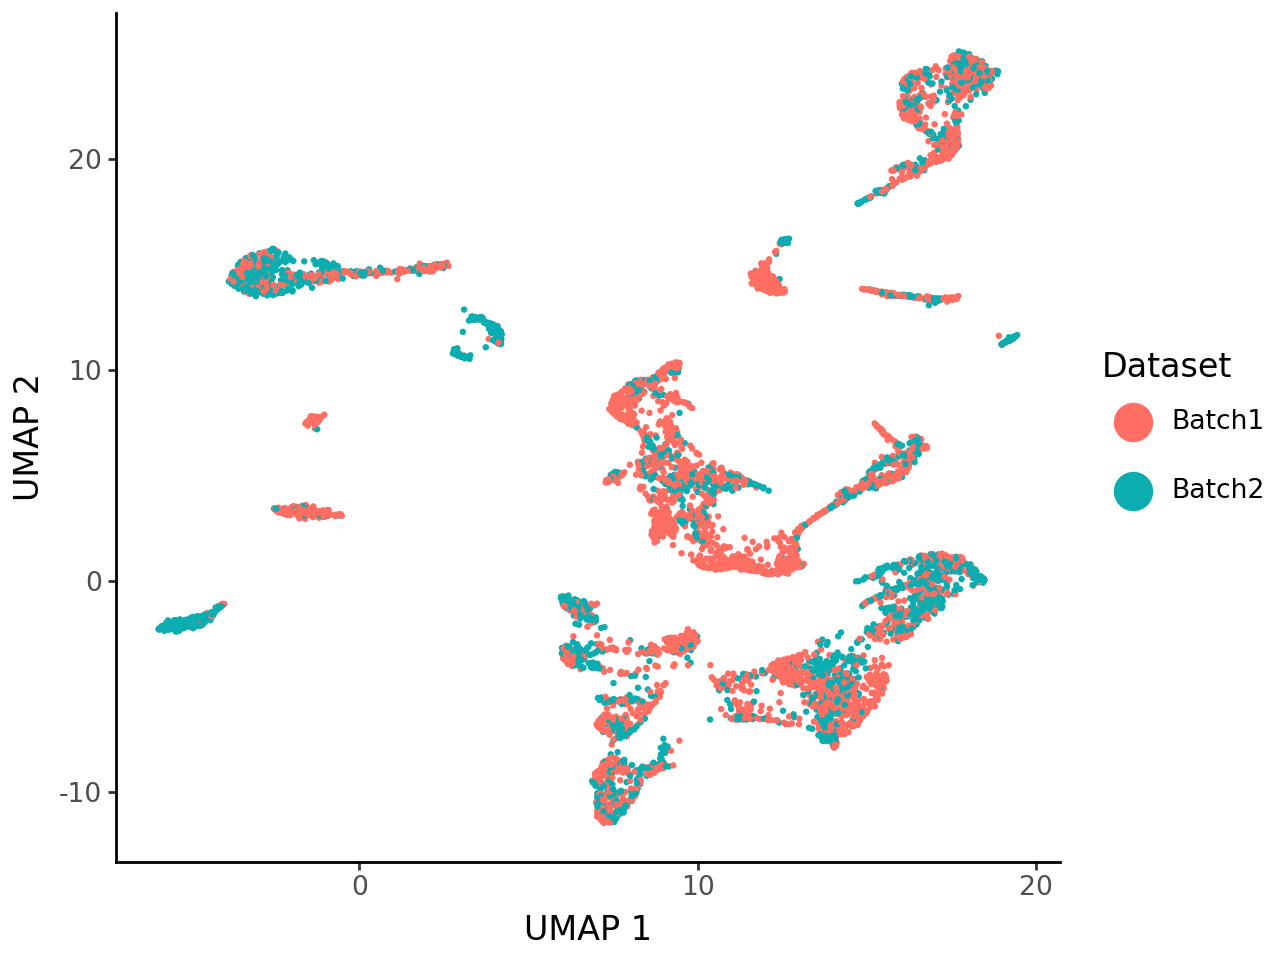

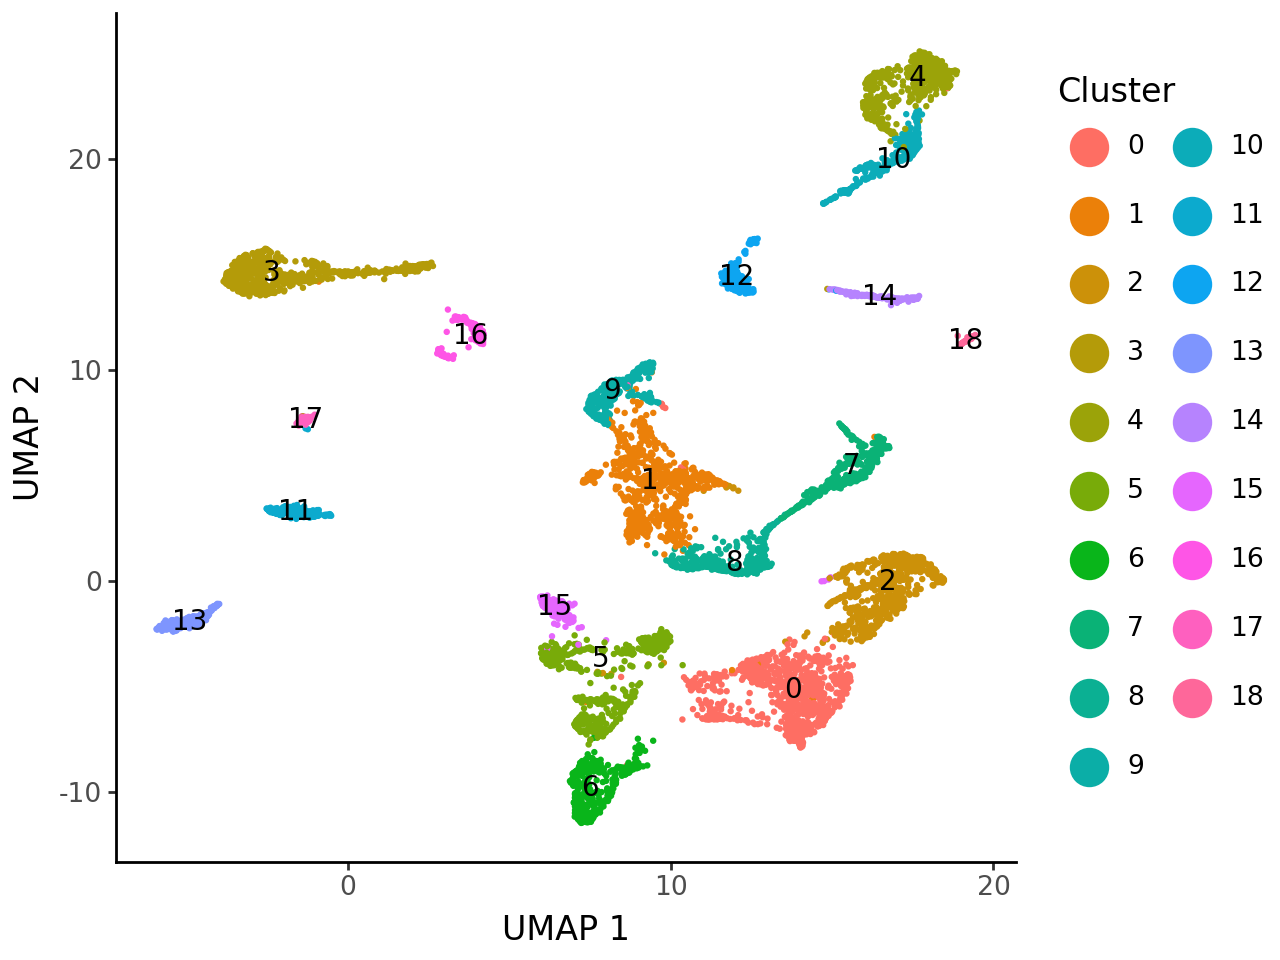

Performing Wilcoxon test on ALL datasets: Batch1, Batch2
Batch Mean LISI Scores: 1.527837830643218
Batch Median LISI Scores: 1.548269625093233
Celltype Mean LISI Scores: 1.236415581915411
Celltype Median LISI Scores: 1.0290366489604743
kBET score: 0.7023080241587576
ASW (CellType): 0.110813207924366
ASW (Batch): 0.02701222151517868
Execution Time: 4.374261379241943 seconds


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [ ]:
%%time

k=30
var_thresh=0.1

try:
    # Create LIGER object from the list of AnnData objects
    liger_object = pyliger.create_liger(adata_list)
except ValueError as e:
    print(f"ValueError occurred while creating LIGER object: {e}")
    print("adata_list:", adata_list)
    raise

# Preprocessing steps (separate function calls)
pyliger.normalize(liger_object)  # Normalize the LIGER object
pyliger.select_genes(liger_object, var_thresh=var_thresh)  # Select variable genes
pyliger.scale_not_center(liger_object)  # Scale data without centering

# Factorization and alignment
pyliger.optimize_ALS(liger_object, k=k, nrep = 1)  # Perform ALS optimization

# Quantile Normalization and Clustering
pyliger.quantile_norm(liger_object)
pyliger.leiden_cluster(liger_object, resolution=0.25)

# Visualization
pyliger.run_umap(liger_object, distance='cosine', n_neighbors=40, min_dist=0.3)
embedding = liger_object.tsne_coords
plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels=['UMAP 1', 'UMAP 2'], return_plots=True)

for plot in plots:
    plt.figure(figsize=(8, 6))
    plot.show()

# Downstream Analysis
cluster_results = pyliger.run_wilcoxon(liger_object, compare_method="clusters")

In [17]:
compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw)

Batch Mean LISI Scores: 1.527837830643218
Batch Median LISI Scores: 1.548269625093233
Celltype Mean LISI Scores: 1.236415581915411
Celltype Median LISI Scores: 1.0290366489604743
kBET score: 0.7023080241587576
ASW (CellType): 0.110813207924366
ASW (Batch): 0.02701222151517868
Execution Time: 4.441086530685425 seconds


100%|██████████| 30/30 [07:13<00:00, 14.46s/it]
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyliger\plotting\_dataset_cluster.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


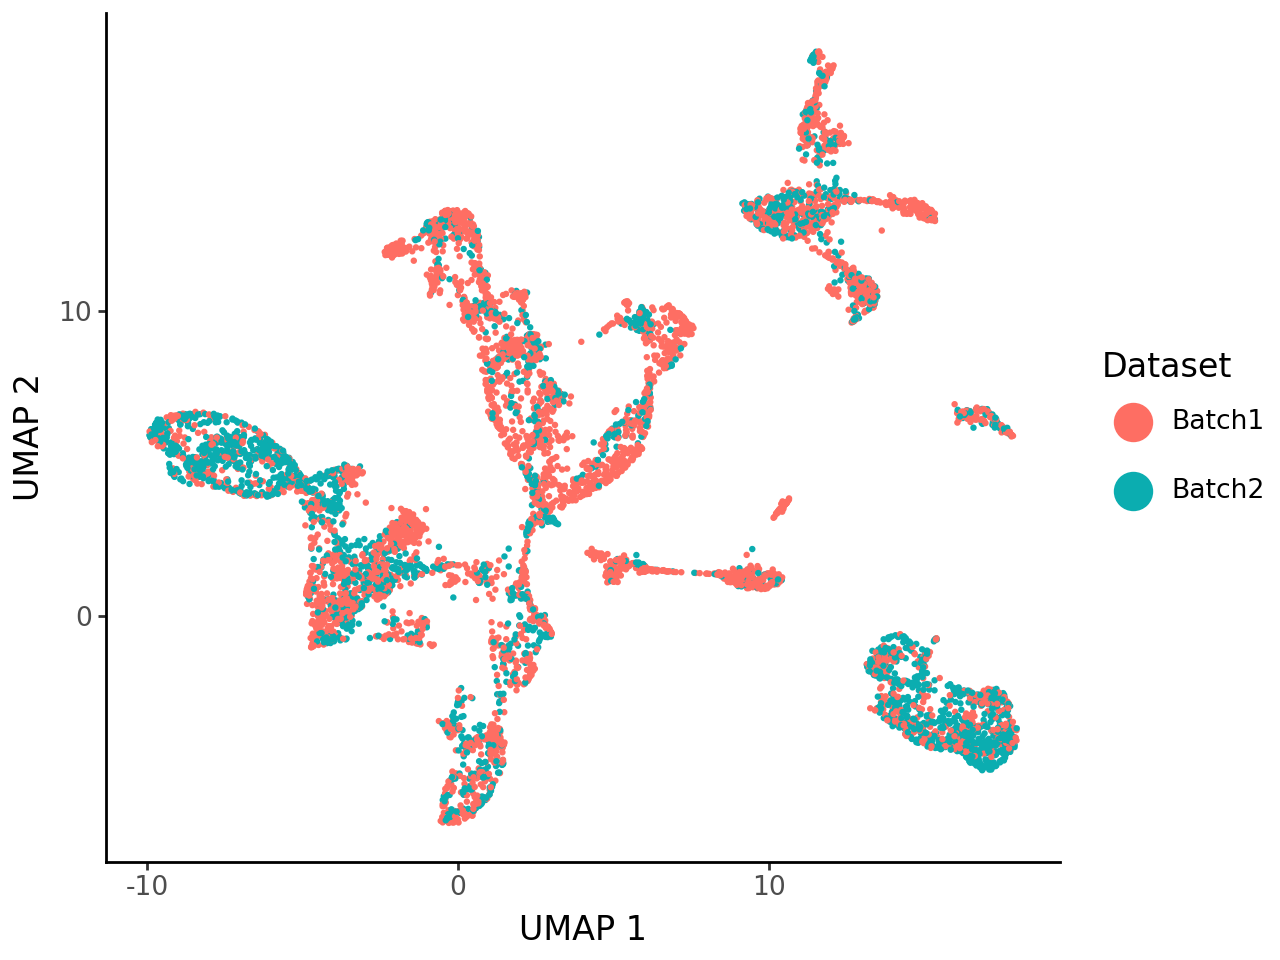

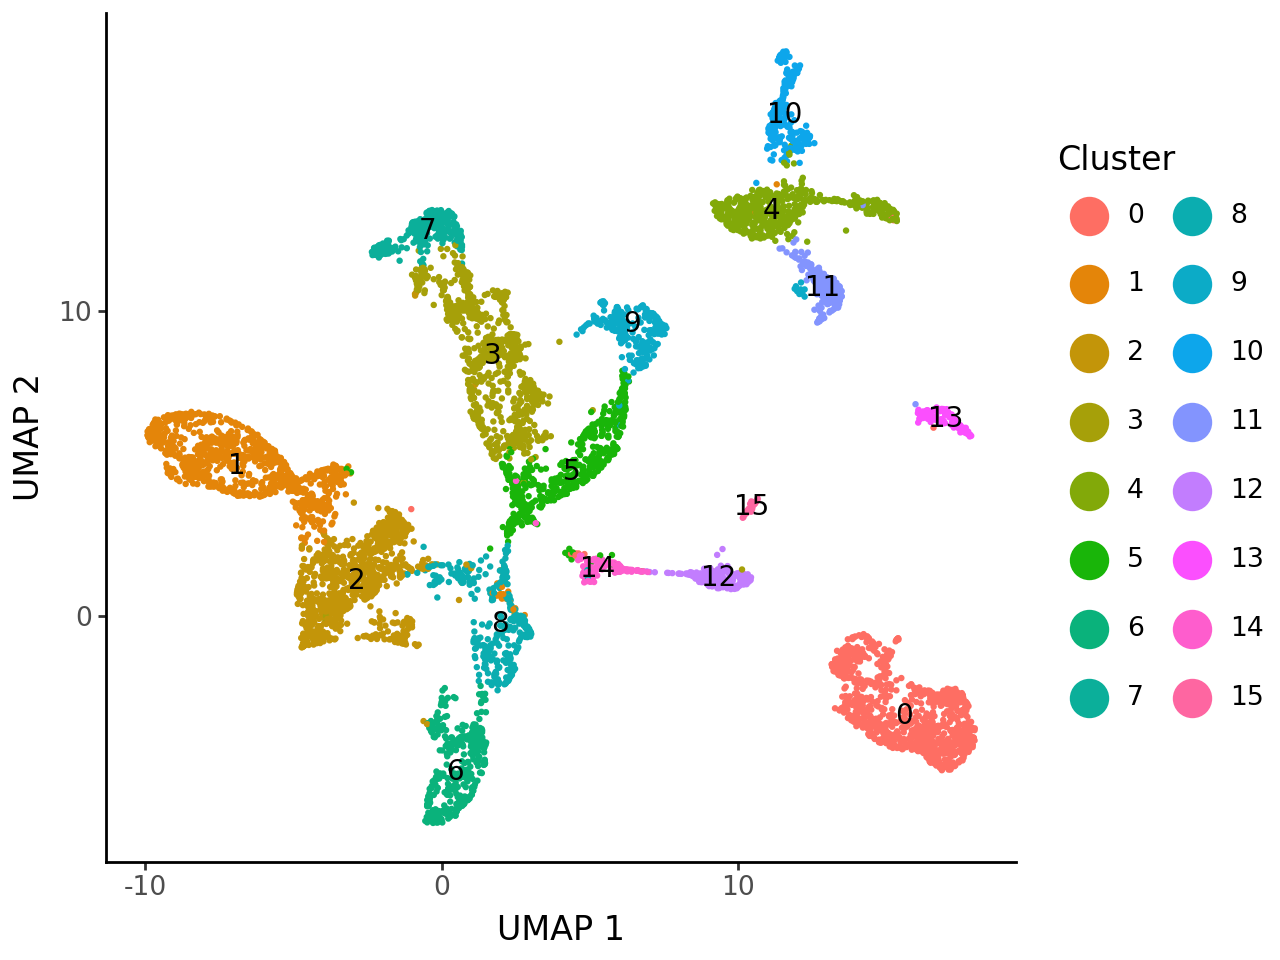

Performing Wilcoxon test on ALL datasets: Batch1, Batch2
CPU times: total: 10min 8s
Wall time: 7min 47s


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [9]:
%%time

k=25
var_thresh=0.1

try:
    # Create LIGER object from the list of AnnData objects
    liger_object = pyliger.create_liger(adata_list)
except ValueError as e:
    print(f"ValueError occurred while creating LIGER object: {e}")
    print("adata_list:", adata_list)
    raise

# Preprocessing steps (separate function calls)
pyliger.normalize(liger_object)  # Normalize the LIGER object
pyliger.select_genes(liger_object, var_thresh=var_thresh)  # Select variable genes
pyliger.scale_not_center(liger_object)  # Scale data without centering

# Factorization and alignment
pyliger.optimize_ALS(liger_object, k=k, nrep = 1)  # Perform ALS optimization

# Quantile Normalization and Clustering
pyliger.quantile_norm(liger_object)
pyliger.leiden_cluster(liger_object, resolution=0.25)

# Visualization
pyliger.run_umap(liger_object, distance='cosine', n_neighbors=40, min_dist=0.3)
embedding = liger_object.tsne_coords
plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels=['UMAP 1', 'UMAP 2'], return_plots=True)

for plot in plots:
    plt.figure(figsize=(8, 6))
    plot.show()

# Downstream Analysis
cluster_results = pyliger.run_wilcoxon(liger_object, compare_method="clusters")

In [10]:
compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw)

Batch Mean LISI Scores: 1.5653087288452767
Batch Median LISI Scores: 1.5946396102872904
Celltype Mean LISI Scores: 1.2519766149964808
Celltype Median LISI Scores: 1.0415077244299142
kBET score 20: 0.6770707506471096
kBET score 30: 0.6630524398427764
kBET score 40: 0.6532679033649698
ASW (CellType): 0.18365903198719025
ASW (Batch): 0.05130006745457649
Execution Time: 5.202459096908569 seconds


100%|██████████| 30/30 [04:18<00:00,  8.61s/it]
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyliger\plotting\_dataset_cluster.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


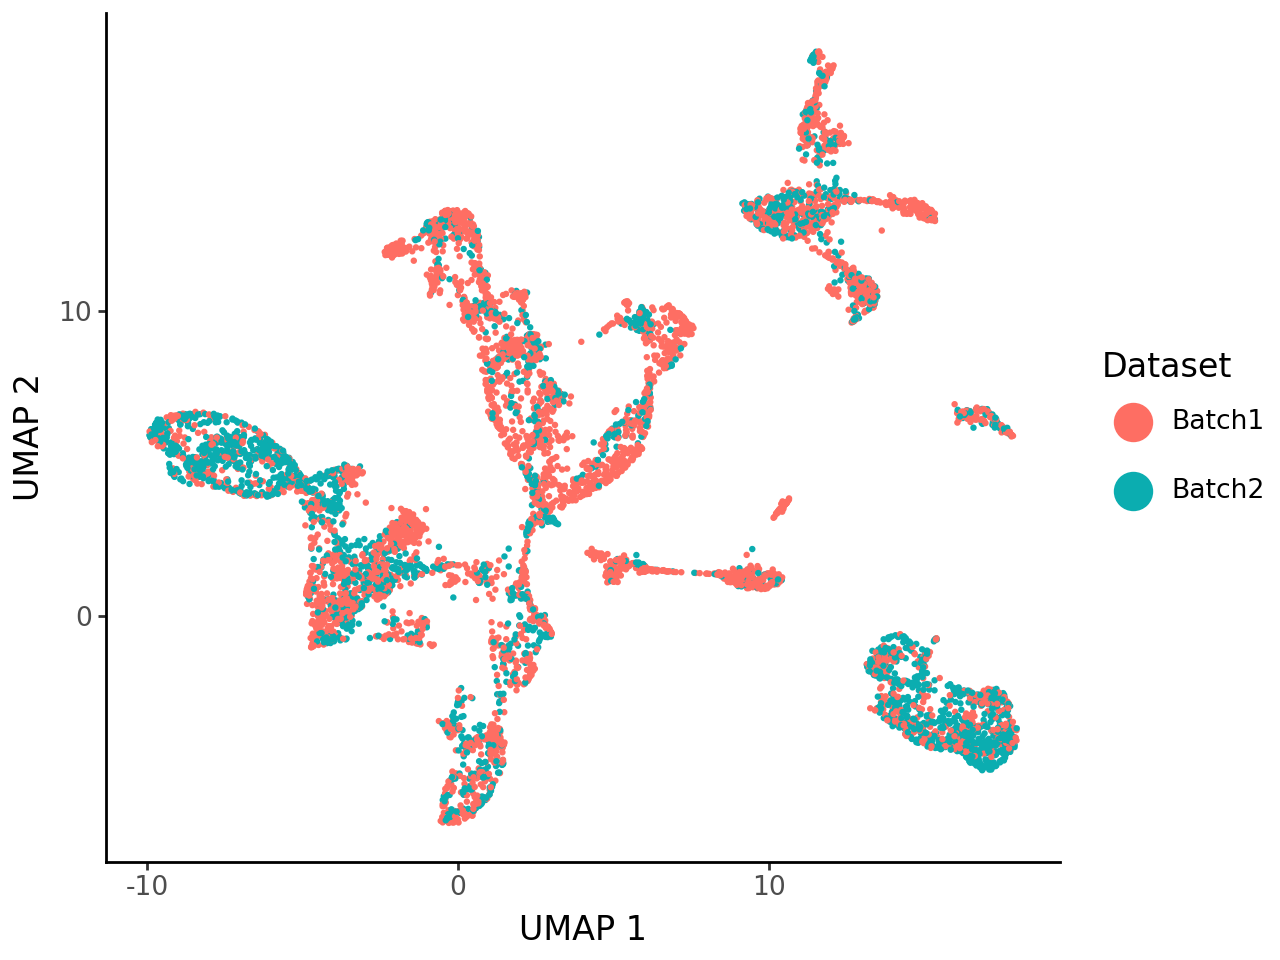

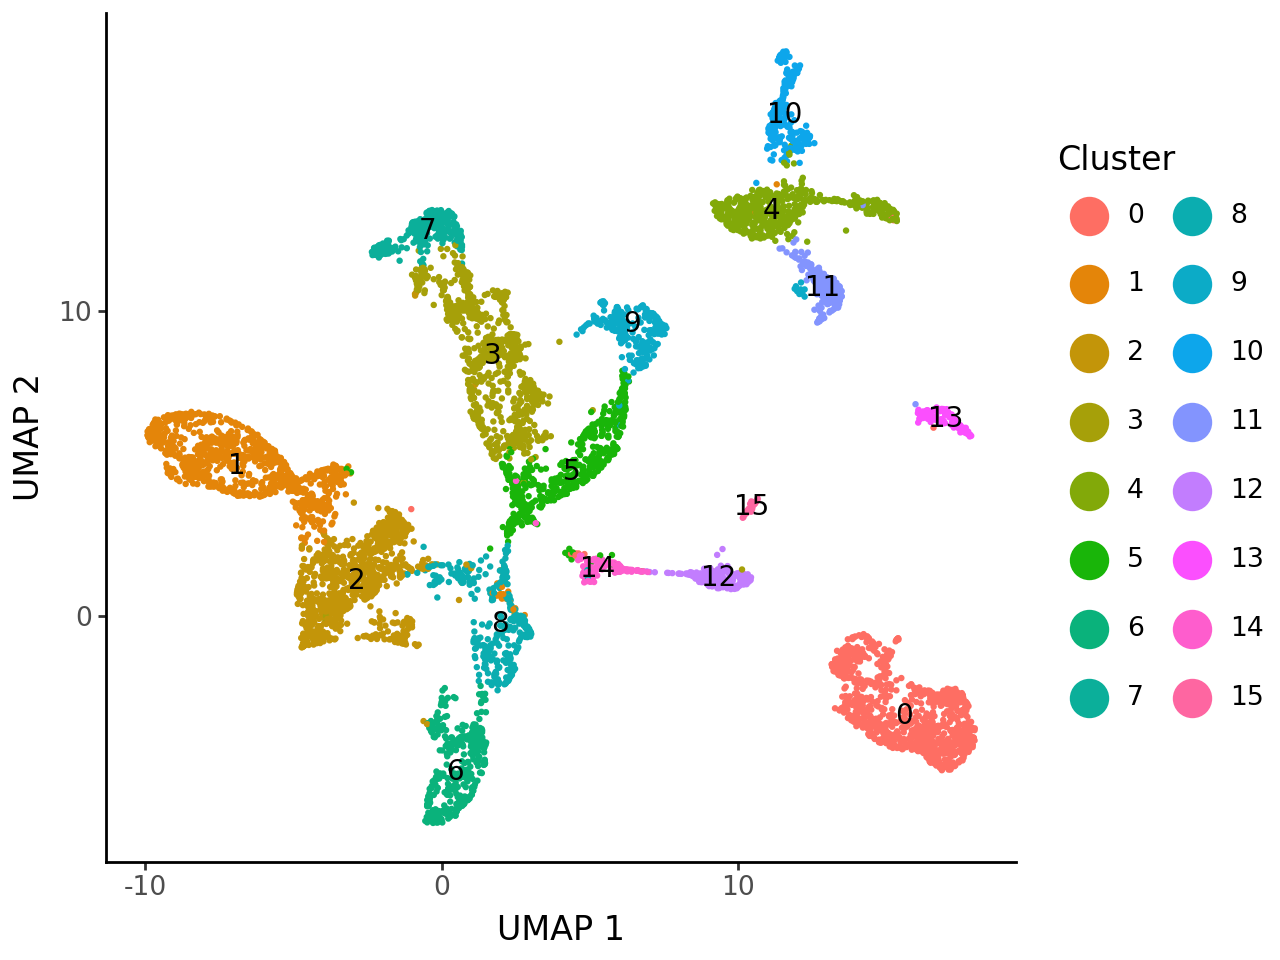

Performing Wilcoxon test on ALL datasets: Batch1, Batch2
CPU times: total: 8min 4s
Wall time: 4min 51s


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [11]:
%%time

k=25
var_thresh=0.01

try:
    # Create LIGER object from the list of AnnData objects
    liger_object = pyliger.create_liger(adata_list)
except ValueError as e:
    print(f"ValueError occurred while creating LIGER object: {e}")
    print("adata_list:", adata_list)
    raise

# Preprocessing steps (separate function calls)
pyliger.normalize(liger_object)  # Normalize the LIGER object
pyliger.select_genes(liger_object, var_thresh=var_thresh)  # Select variable genes
pyliger.scale_not_center(liger_object)  # Scale data without centering

# Factorization and alignment
pyliger.optimize_ALS(liger_object, k=k, nrep = 1)  # Perform ALS optimization

# Quantile Normalization and Clustering
pyliger.quantile_norm(liger_object)
pyliger.leiden_cluster(liger_object, resolution=0.25)

# Visualization
pyliger.run_umap(liger_object, distance='cosine', n_neighbors=40, min_dist=0.3)
embedding = liger_object.tsne_coords
plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels=['UMAP 1', 'UMAP 2'], return_plots=True)

for plot in plots:
    plt.figure(figsize=(8, 6))
    plot.show()

# Downstream Analysis
cluster_results = pyliger.run_wilcoxon(liger_object, compare_method="clusters")

In [12]:
compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw)

Batch Mean LISI Scores: 1.5653087288452767
Batch Median LISI Scores: 1.5946396102872904
Celltype Mean LISI Scores: 1.2519766149964808
Celltype Median LISI Scores: 1.0415077244299142
kBET score 20: 0.6770707506471096
kBET score 30: 0.6630524398427764
kBET score 40: 0.6532679033649698
ASW (CellType): 0.18365903198719025
ASW (Batch): 0.05130006745457649
Execution Time: 4.858482599258423 seconds


100%|██████████| 30/30 [02:59<00:00,  6.00s/it]
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyliger\plotting\_dataset_cluster.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


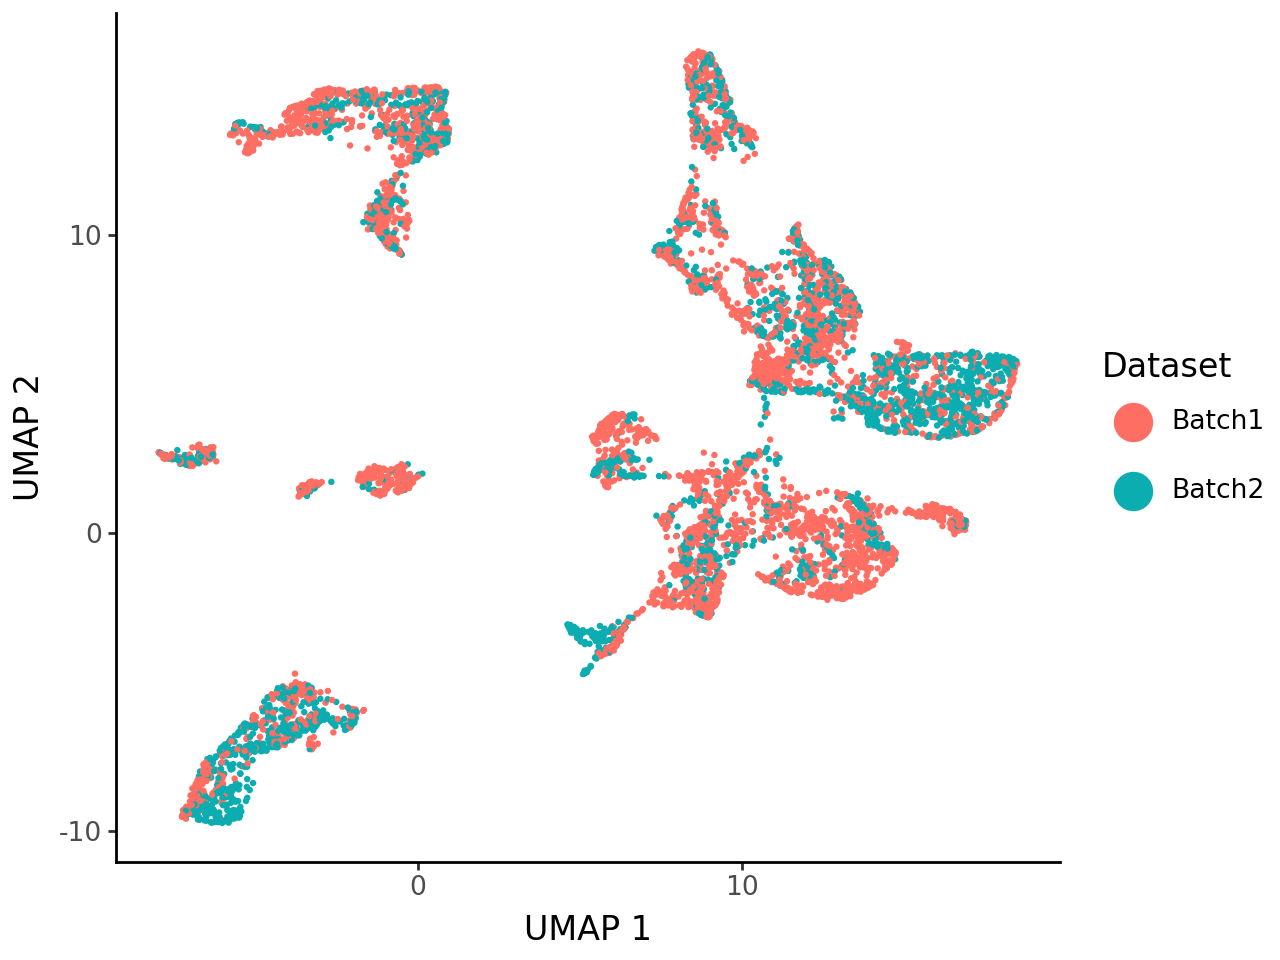

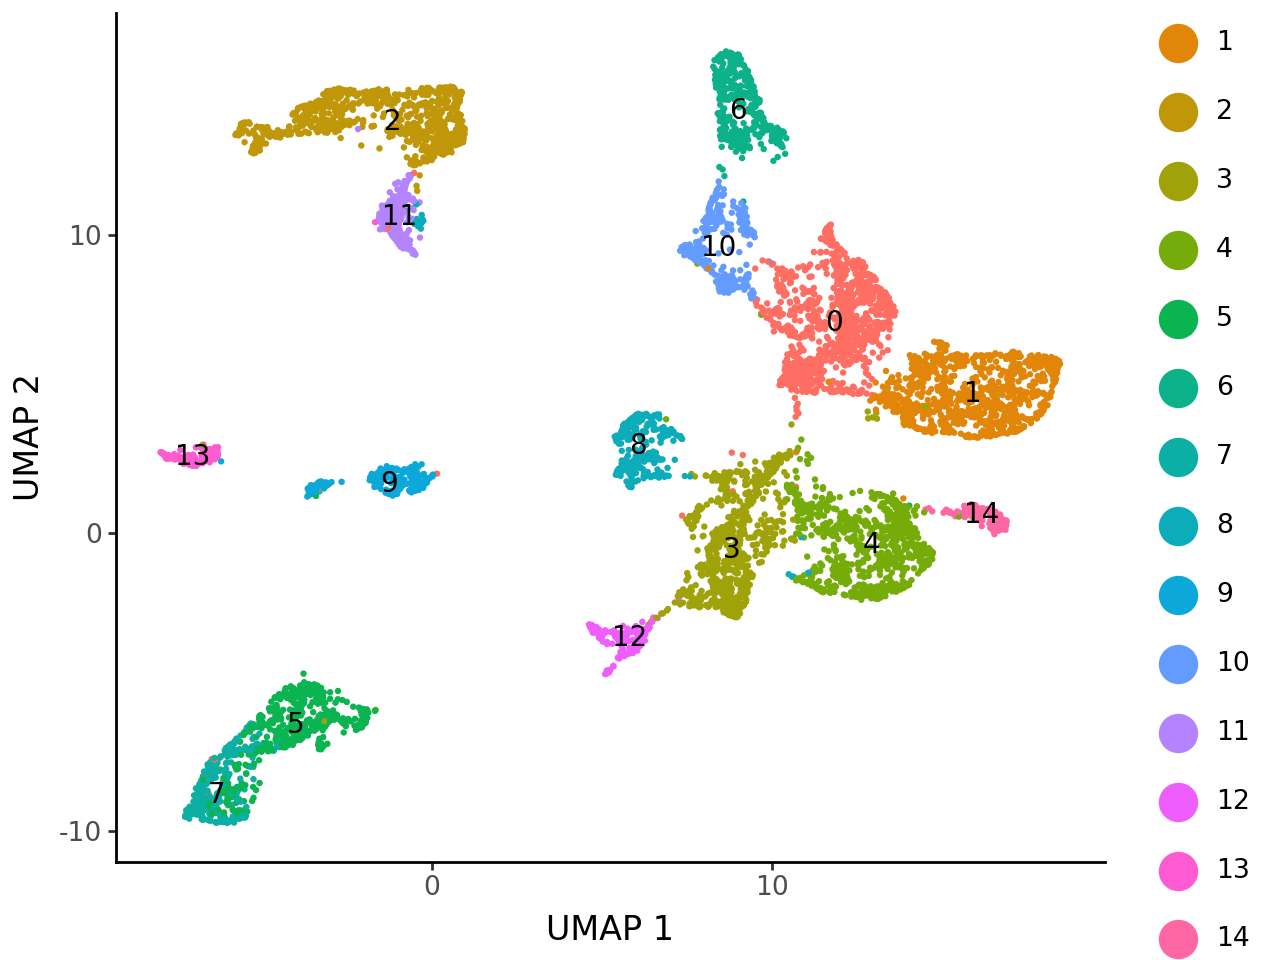

Performing Wilcoxon test on ALL datasets: Batch1, Batch2
CPU times: total: 7min 23s
Wall time: 3min 31s


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [22]:
%%time

k=20
var_thresh=0.01

try:
    # Create LIGER object from the list of AnnData objects
    liger_object = pyliger.create_liger(adata_list)
except ValueError as e:
    print(f"ValueError occurred while creating LIGER object: {e}")
    print("adata_list:", adata_list)
    raise

# Preprocessing steps (separate function calls)
pyliger.normalize(liger_object)  # Normalize the LIGER object
pyliger.select_genes(liger_object, var_thresh=var_thresh)  # Select variable genes
pyliger.scale_not_center(liger_object)  # Scale data without centering

# Factorization and alignment
pyliger.optimize_ALS(liger_object, k=k, nrep = 1)  # Perform ALS optimization

# Quantile Normalization and Clustering
pyliger.quantile_norm(liger_object)
pyliger.leiden_cluster(liger_object, resolution=0.25)

# Visualization
pyliger.run_umap(liger_object, distance='cosine', n_neighbors=40, min_dist=0.3)
embedding = liger_object.tsne_coords
plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels=['UMAP 1', 'UMAP 2'], return_plots=True)

for plot in plots:
    plt.figure(figsize=(8, 6))
    plot.show()

# Downstream Analysis
cluster_results = pyliger.run_wilcoxon(liger_object, compare_method="clusters")

In [23]:
compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw)

Batch Mean LISI Scores: 1.5683434103184923
Batch Median LISI Scores: 1.614216693153907
Celltype Mean LISI Scores: 1.3254225600817255
Celltype Median LISI Scores: 1.0529228137006648
kBET score: 0.6793284440609721
ASW (CellType): 0.15727929770946503
ASW (Batch): 0.031304534524679184
Execution Time: 4.496662378311157 seconds


100%|██████████| 30/30 [03:08<00:00,  6.27s/it]
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyliger\plotting\_dataset_cluster.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


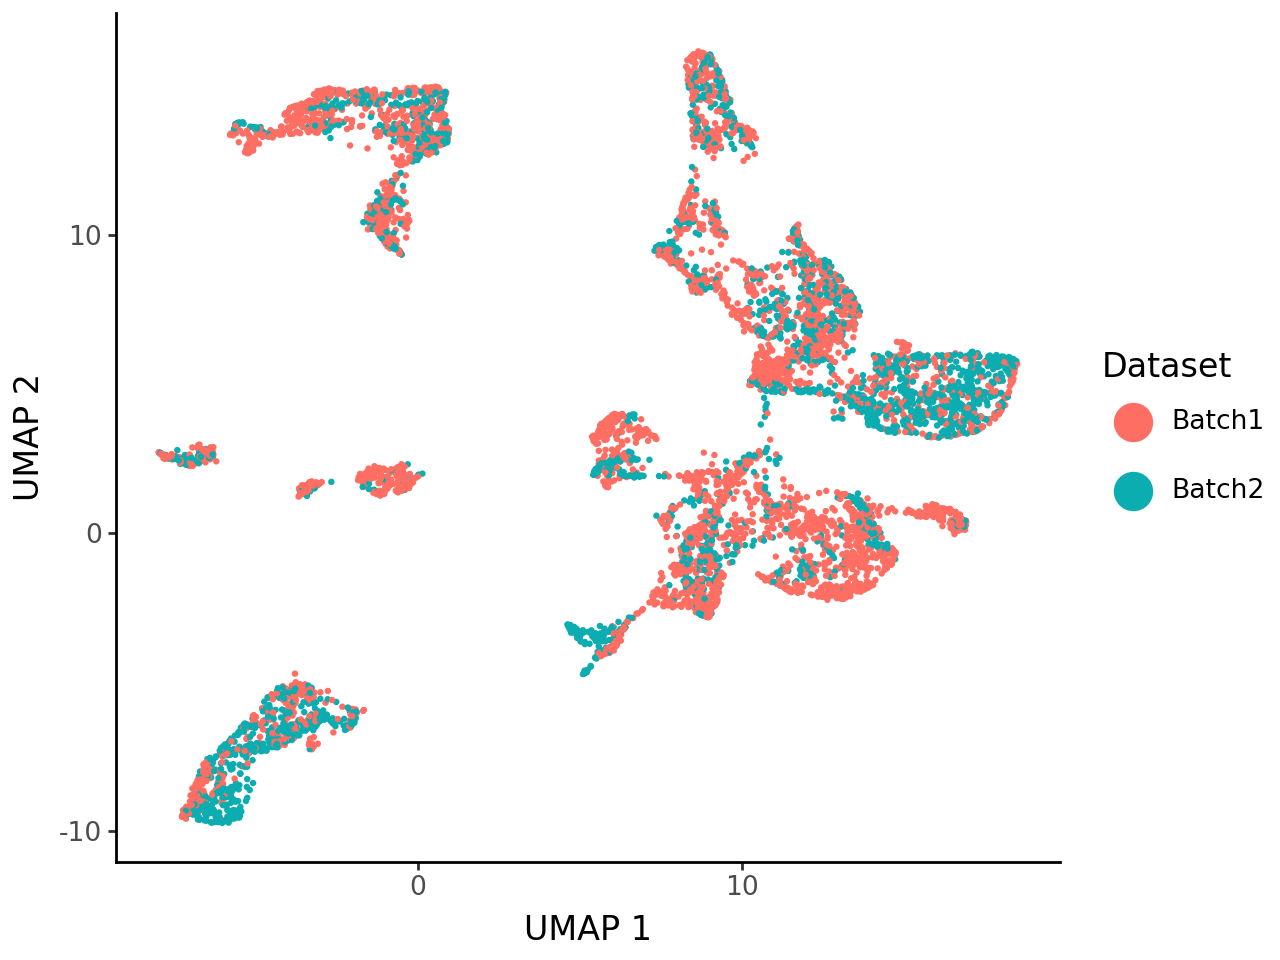

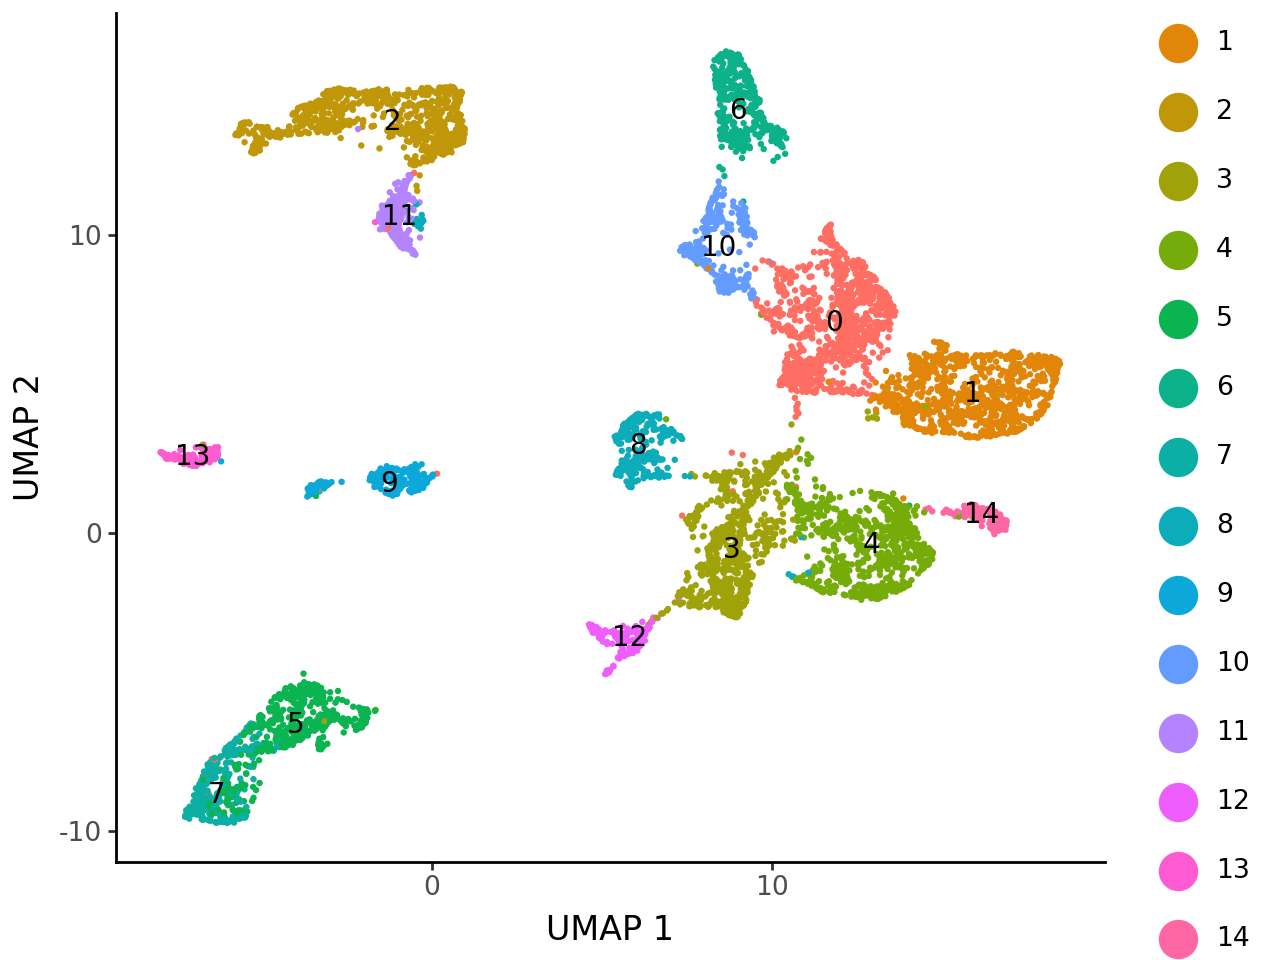

Performing Wilcoxon test on ALL datasets: Batch1, Batch2
CPU times: total: 7min 28s
Wall time: 3min 44s


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [29]:
%%time

k=20
var_thresh=0.2

try:
    # Create LIGER object from the list of AnnData objects
    liger_object = pyliger.create_liger(adata_list)
except ValueError as e:
    print(f"ValueError occurred while creating LIGER object: {e}")
    print("adata_list:", adata_list)
    raise

# Preprocessing steps (separate function calls)
pyliger.normalize(liger_object)  # Normalize the LIGER object
pyliger.select_genes(liger_object, var_thresh=var_thresh)  # Select variable genes
pyliger.scale_not_center(liger_object)  # Scale data without centering

# Factorization and alignment
pyliger.optimize_ALS(liger_object, k=k, nrep = 1)  # Perform ALS optimization

# Quantile Normalization and Clustering
pyliger.quantile_norm(liger_object)
pyliger.leiden_cluster(liger_object, resolution=0.25)

# Visualization
pyliger.run_umap(liger_object, distance='cosine', n_neighbors=40, min_dist=0.3)
embedding = liger_object.tsne_coords
plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels=['UMAP 1', 'UMAP 2'], return_plots=True)

for plot in plots:
    plt.figure(figsize=(8, 6))
    plot.show()

# Downstream Analysis
cluster_results = pyliger.run_wilcoxon(liger_object, compare_method="clusters")

In [30]:
compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw)

Batch Mean LISI Scores: 1.5683434103184923
Batch Median LISI Scores: 1.614216693153907
Celltype Mean LISI Scores: 1.3254225600817255
Celltype Median LISI Scores: 1.0529228137006648
kBET score: 0.6793284440609721
ASW (CellType): 0.15727929770946503
ASW (Batch): 0.031304534524679184
Execution Time: 4.491856098175049 seconds


100%|██████████| 30/30 [32:37<00:00, 65.25s/it]
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyliger\plotting\_dataset_cluster.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


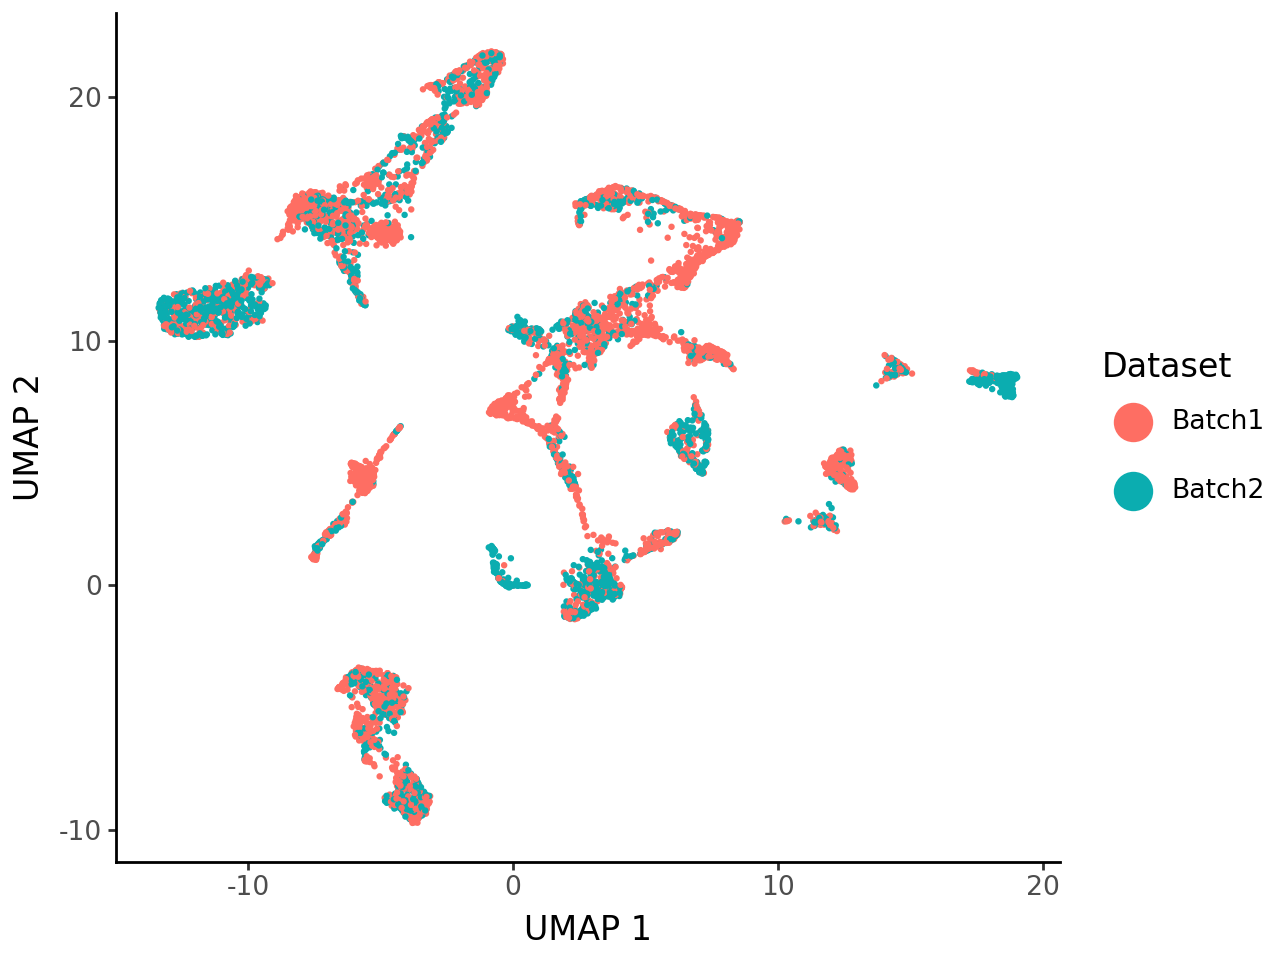

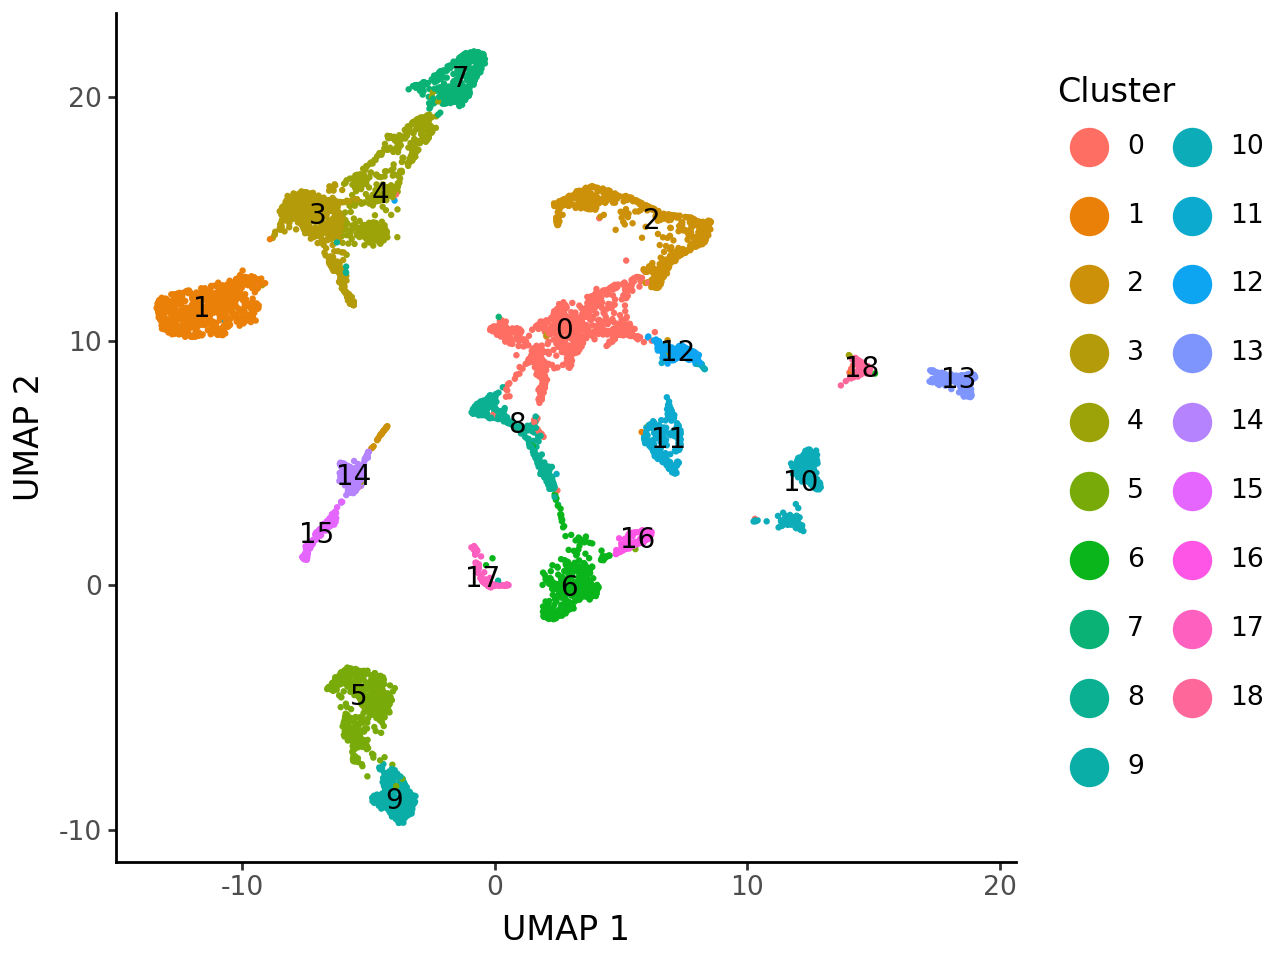

Performing Wilcoxon test on ALL datasets: Batch1, Batch2
CPU times: total: 50min 37s
Wall time: 33min 41s


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [27]:
%%time

k=40
var_thresh=0.1

try:
    # Create LIGER object from the list of AnnData objects
    liger_object = pyliger.create_liger(adata_list)
except ValueError as e:
    print(f"ValueError occurred while creating LIGER object: {e}")
    print("adata_list:", adata_list)
    raise

# Preprocessing steps (separate function calls)
pyliger.normalize(liger_object)  # Normalize the LIGER object
pyliger.select_genes(liger_object, var_thresh=var_thresh)  # Select variable genes
pyliger.scale_not_center(liger_object)  # Scale data without centering

# Factorization and alignment
pyliger.optimize_ALS(liger_object, k=k, nrep = 1)  # Perform ALS optimization

# Quantile Normalization and Clustering
pyliger.quantile_norm(liger_object)
pyliger.leiden_cluster(liger_object, resolution=0.25)

# Visualization
pyliger.run_umap(liger_object, distance='cosine', n_neighbors=40, min_dist=0.3)
embedding = liger_object.tsne_coords
plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels=['UMAP 1', 'UMAP 2'], return_plots=True)

for plot in plots:
    plt.figure(figsize=(8, 6))
    plot.show()

# Downstream Analysis
cluster_results = pyliger.run_wilcoxon(liger_object, compare_method="clusters")

In [28]:
compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw)

Batch Mean LISI Scores: 1.5517119158722872
Batch Median LISI Scores: 1.612741454577801
Celltype Mean LISI Scores: 1.2601578463150098
Celltype Median LISI Scores: 1.0295453038717284
kBET score: 0.6890997986770204
ASW (CellType): 0.03925086185336113
ASW (Batch): 0.02600097469985485
Execution Time: 4.60664963722229 seconds


### Metrics

In [10]:
%%time

# Convert to a DataFrame for alignment with metadata
embedding_df = pd.DataFrame(embedding, index=metadata.index, columns=['UMAP1', 'UMAP2'])

metadata['batch'] = metadata['batch'].astype('category')
metadata['CellType'] = metadata['CellType'].astype('category')

# Example call to compute LISI for both batch and cell type
label_colnames = ["batch", "CellType"]  # Modify as per your metadata
lisi_scores = compute_lisi(
    X=embedding[["tsne1", "tsne2"]].values,            # UMAP or PCA embedding (cells x dimensions)
    metadata=metadata,      # DataFrame with batch/celltype information
    label_colnames=label_colnames,
    perplexity=30           # Adjust perplexity based on dataset size
)

# Separate LISI scores for each label
lisi_batch = lisi_scores[:, 0]  # LISI scores for "batch"
lisi_celltype = lisi_scores[:, 1]  # LISI scores for "celltype"

# Output the LISI results
print("Batch Mean LISI Scores:", lisi_batch.mean())
print("Batch Median LISI Scores:", np.median(lisi_batch))
print("Celltype Mean LISI Scores:", lisi_celltype.mean())
print("Celltype Median LISI Scores:", np.median(lisi_celltype))

kbet_score = calculate_kbet(embedding[["tsne1", "tsne2"]].values, metadata['batch'].values, k=20)
print(f"kBET score: {kbet_score}")

# Assuming `tsne_coords` is your DataFrame
embedding_columns = ['tsne1', 'tsne2']

embedding_df['CellType'] = metadata['CellType'].astype('category')
embedding['CellType'] = embedding_df.reset_index()['CellType']

# Calculate ASW for clusters
asw_cluster = calculate_asw(embedding, embeddings_columns=embedding_columns, labels_column='CellType')
print(f"ASW (CellType): {asw_cluster}")

# Calculate ASW for batches (datasets)
asw_batch = calculate_asw(embedding, embeddings_columns=embedding_columns, labels_column='Dataset')
print(f"ASW (Batch): {asw_batch}")


Batch Mean LISI Scores: 1.5665148401186768
Batch Median LISI Scores: 1.6024287181546941
Celltype Mean LISI Scores: 1.3199464364480056
Celltype Median LISI Scores: 1.0525280876532865
kBET score: 0.6815358067299395
ASW (CellType): 0.1296955794095993
ASW (Batch): 0.028652753680944443
CPU times: total: 4.38 s
Wall time: 4.34 s


## HARMONY

In [6]:
%%time

batch_label='batchlb'
celltype_label='CellType'

# Check if batch_label exists in metadata
if batch_label not in metadata.columns:
    raise ValueError(f"'{batch_label}' not found in metadata columns.")

# Separate datasets by batch
datasets = {}
for batch in metadata[batch_label].unique():
    batch_cells = metadata[metadata[batch_label] == batch].index
    datasets[batch] = expr_mat.loc[:, batch_cells]

# Convert each batch dataset into an AnnData object
adata_list = []
for batch, dataset in datasets.items():
    # Ensure unique cell names (obs)
    cell_names = dataset.columns
    if not cell_names.is_unique:
        raise ValueError(f"Cell names are not unique in batch {batch}. Please ensure all cell names are unique.")
    
    # Ensure unique gene names (var)
    gene_names = expr_mat.index
    if not gene_names.is_unique:
        raise ValueError(f"Gene names are not unique in the expression matrix. Please ensure all gene names are unique.")
    
    # Create an AnnData object for each batch dataset
    adata = sc.AnnData(
        X=dataset.T,  # Transpose the dataset to have cells as rows and genes as columns
        obs=metadata.loc[dataset.columns],  # Metadata corresponding to cells
        var=pd.DataFrame(index=expr_mat.index)  # Ensure 'var' is a DataFrame with gene names
    )
    
    # Explicitly set names for obs and var indices
    adata.obs.index.name = 'cell_names'
    adata.var.index.name = 'gene_names'
    
    # Add the 'sample_name' key to uns (if not already there)
    adata.uns['sample_name'] = batch  # Assign the batch name as sample name
    
    # Check that indices are unique and populated
    if not adata.obs.index.is_unique:
        raise ValueError(f"Cell names are not unique in the AnnData object for batch {batch}.")
    
    if not adata.var.index.is_unique:
        raise ValueError(f"Gene names are not unique in the AnnData object for batch {batch}.")
    
    # Debugging output
    print(f"Batch: {batch}, Number of cells: {adata.n_obs}, Number of genes: {adata.n_vars}")
    
    # Verify that the AnnData object has both row (cell) and column (gene) names
    print(f"First 5 cell names: {adata.obs.index[:5]}")
    print(f"First 5 gene names: {adata.var.index[:5]}")
    
    adata_list.append(adata)


Batch: Batch1, Number of cells: 4239, Number of genes: 15006
First 5 cell names: Index(['T-cell_Thymus_1.GCGTCCGGTACACCGCTA',
       'T-cell_Thymus_2.CGAGTATAGTCGGTCGGT',
       'T-cell_Thymus_1.TGAAGCTCAAAGCGCTTG',
       'T-cell_Thymus_1.TTAACTTATTGTGTATAC',
       'T-cell_Thymus_1.GACACTATTCCACAAAGT'],
      dtype='object', name='cell_names')
First 5 gene names: Index(['0610005C13Rik', '0610007N19Rik', '0610007P14Rik', '0610009B22Rik',
       '0610009D07Rik'],
      dtype='object', name='gene_names')
Batch: Batch2, Number of cells: 2715, Number of genes: 15006
First 5 cell names: Index(['Smooth-muscle_F14.MAA000594.3_8_M.1.1',
       'Smooth-muscle_L22.MAA000594.3_8_M.1.1',
       'Smooth-muscle_B21.MAA000594.3_8_M.1.1',
       'Smooth-muscle_G12.MAA000594.3_8_M.1.1',
       'Smooth-muscle_I22.MAA000594.3_8_M.1.1'],
      dtype='object', name='cell_names')
First 5 gene names: Index(['0610005C13Rik', '0610007N19Rik', '0610007P14Rik', '0610009B22Rik',
       '0610009D07Rik'],
      dt

<timed exec>:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


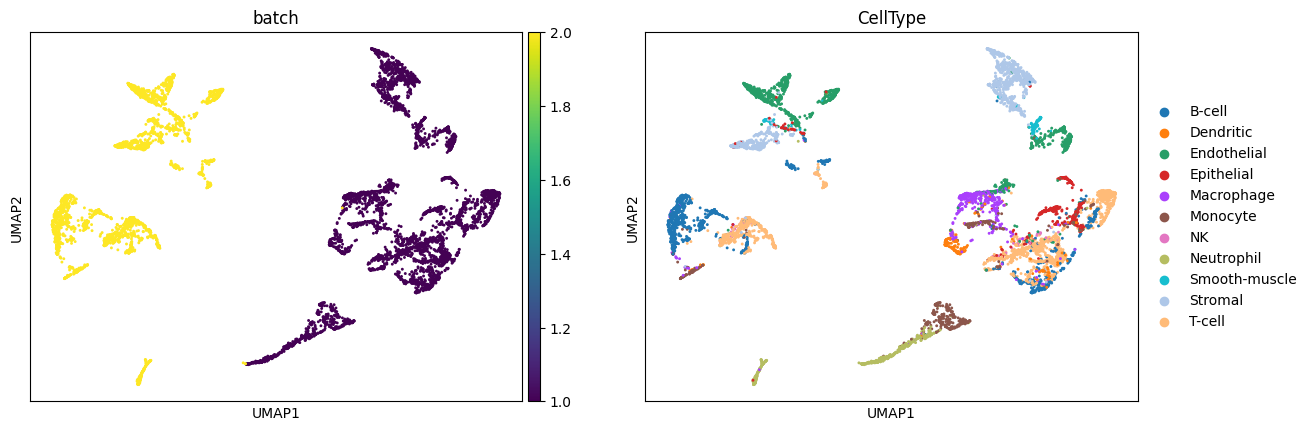

CPU times: total: 34.4 s
Wall time: 38 s


In [8]:
%%time

# Now, perform Harmony on the combined AnnData object instead of a single batch
combined_adata = adata_list[0].concatenate(adata_list[1:], batch_key=batch_label)

# Ensure PCA is already computed (if not, run PCA)
sc.tl.pca(combined_adata, svd_solver='arpack')

# Apply Harmony to the PCA coordinates (on combined data)
combined_adata.obsm['X_pca_harmony'] = harmonize(
    combined_adata.obsm['X_pca'],  # PCA embeddings
    combined_adata.obs,            # Cell metadata
    batch_key=batch_label          # Column name in `obs` for batch information
)

# Replace PCA coordinates with Harmony-corrected embeddings
combined_adata.obsm['X_pca'] = combined_adata.obsm['X_pca_harmony']

# Recompute neighbors and UMAP using Harmony-corrected data
sc.pp.neighbors(combined_adata, n_neighbors=20, n_pcs=40)
sc.tl.umap(combined_adata, min_dist=0.1, spread=1.5)

# Plot UMAP with batch and cell type coloring
sc.pl.umap(combined_adata, color=['batch', 'CellType'], save="_harmony_umap.png")

In [60]:
%%time

# Embedding (Harmony-corrected PCA embeddings)
embedding = combined_adata.obsm['X_pca_harmony']  # Use Harmony embeddings (or UMAP/PCA)

# Convert embedding to DataFrame for alignment with metadata
embedding_df = pd.DataFrame(embedding, index=combined_adata.obs.index, columns=[f'PCA{i+1}' for i in range(50)])

# Ensure metadata is aligned and categorical columns are set properly
combined_adata.obs['batch'] = combined_adata.obs['batch'].astype('category')
combined_adata.obs['CellType'] = combined_adata.obs['CellType'].astype('category')

# Call the compute_lisi function for both "batch" and "celltype"
label_colnames = ["batch", "CellType"]
lisi_scores = compute_lisi(
    X=embedding,         # Harmony embeddings (cells x dimensions)
    metadata=combined_adata.obs,  # Metadata with batch/celltype info
    label_colnames=label_colnames    # Adjust based on your dataset size
)

# Separate LISI scores for each label
lisi_batch = lisi_scores[:, 0]  # LISI scores for "batch"
lisi_celltype = lisi_scores[:, 1]  # LISI scores for "celltype"

# Output the LISI results
print("Batch Mean LISI Scores:", lisi_batch.mean())
print("Batch Median LISI Scores:", np.median(lisi_batch))
print("Celltype Mean LISI Scores:", lisi_celltype.mean())
print("Celltype Median LISI Scores:", np.median(lisi_celltype))

batch_labels = combined_adata.obs['batch']
kbet_score = calculate_kbet(embedding[:, :2], batch_labels, k=20)  # Use the first 2 columns
print(f"kBET score: {kbet_score}")

# Add the cluster labels to the embedding dataframe
embedding_df['CellType'] = combined_adata.obs['CellType'].values  # Replace with the actual column name

# Now compute ASW for clusters
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='CellType')
print(f"ASW (CellType): {asw_cluster}")

# Add the batch labels (or clusters, cell types) to the embedding dataframe
embedding_df['batch'] = combined_adata.obs['batch'].values  # Adjust for the correct label column

# Now compute ASW for clusters or batches
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='batch')
print(f"ASW (Batch): {asw_cluster}")

Batch Mean LISI Scores: 1.0206825169981057
Batch Median LISI Scores: 1.0
Celltype Mean LISI Scores: 1.311903881815697
Celltype Median LISI Scores: 1.0473812834934142
CPU times: total: 4.14 s
Wall time: 4.41 s


<timed exec>:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


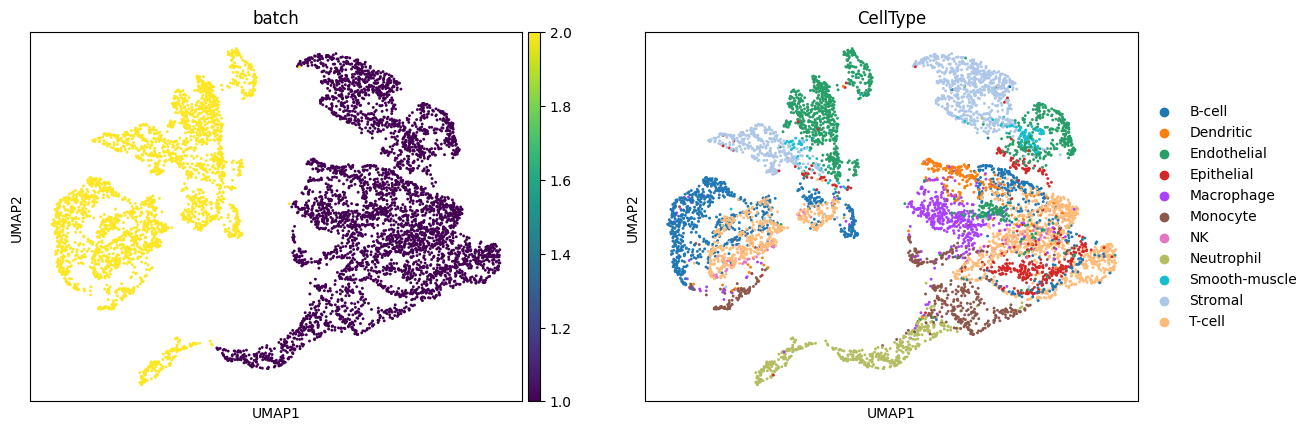

CPU times: total: 18.3 s
Wall time: 15 s


In [8]:
%%time

# Now, perform Harmony on the combined AnnData object instead of a single batch
combined_adata = adata_list[0].concatenate(adata_list[1:], batch_key=batch_label)

# Ensure PCA is already computed (if not, run PCA)
sc.tl.pca(combined_adata, svd_solver='arpack')

# Apply Harmony to the PCA coordinates (on combined data)
# Apply Harmony to the PCA coordinates (on combined data)
combined_adata.obsm['X_pca_harmony'] = harmonize(
    combined_adata.obsm['X_pca'],  # PCA embeddings
    combined_adata.obs,            
    batch_key=batch_label,        
    n_clusters=11,                
    max_iter_harmony=10,           
    max_iter_clustering=200,       
    tol_harmony=1e-4,              
    tol_clustering=1e-5,          
    ridge_lambda=1.0,           
    sigma=0.1,                     
    block_proportion=0.05,         
    theta=2.0,                    
    tau=0,                         
    correction_method='fast',     
    random_state=0,               
    use_gpu=False,            
    n_jobs=-1,               
    verbose=True                 
)

# Replace PCA coordinates with Harmony-corrected embeddings
combined_adata.obsm['X_pca'] = combined_adata.obsm['X_pca_harmony']

# Recompute neighbors and UMAP using Harmony-corrected data
sc.pp.neighbors(combined_adata, n_neighbors=20, n_pcs=40)
sc.tl.umap(combined_adata, min_dist=0.1, spread=1.5)

# Plot UMAP with batch and cell type coloring
sc.pl.umap(combined_adata, color=['batch', 'CellType'], save="_harmony_umap.png")

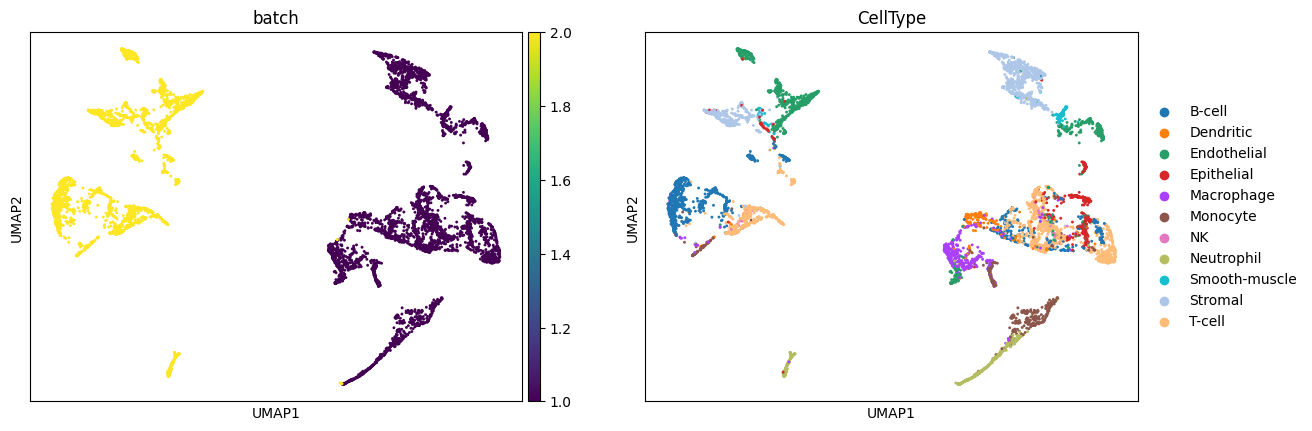

In [9]:
# Replace PCA coordinates with Harmony-corrected embeddings
combined_adata.obsm['X_pca'] = combined_adata.obsm['X_pca_harmony']

# Recompute neighbors and UMAP using Harmony-corrected data
sc.pp.neighbors(combined_adata, n_neighbors=20, n_pcs=40)
sc.tl.umap(combined_adata, min_dist=0.1)

# Plot UMAP with batch and cell type coloring
sc.pl.umap(combined_adata, color=['batch', 'CellType'], save="_harmony_umap.png")

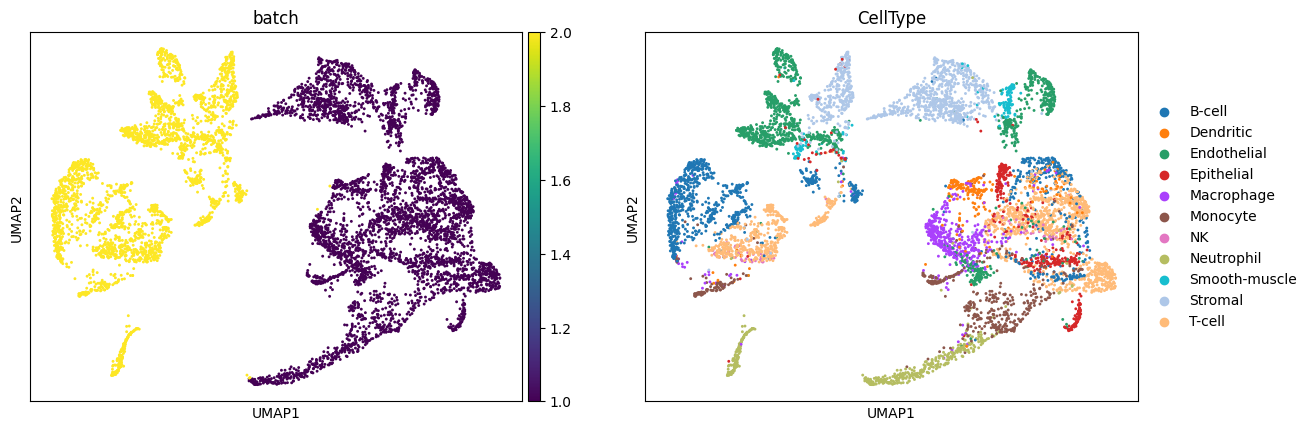

In [11]:
# Replace PCA coordinates with Harmony-corrected embeddings
combined_adata.obsm['X_pca'] = combined_adata.obsm['X_pca_harmony']

# Recompute neighbors and UMAP using Harmony-corrected data
sc.pp.neighbors(combined_adata, n_neighbors=30, n_pcs=40)
sc.tl.umap(combined_adata, spread=1.5)

# Plot UMAP with batch and cell type coloring
sc.pl.umap(combined_adata, color=['batch', 'CellType'], save="_harmony_umap.png")

In [9]:
%%time

# Embedding (Harmony-corrected PCA embeddings)
embedding = combined_adata.obsm['X_pca_harmony']  # Use Harmony embeddings (or UMAP/PCA)

# Convert embedding to DataFrame for alignment with metadata
embedding_df = pd.DataFrame(embedding, index=combined_adata.obs.index, columns=[f'PCA{i+1}' for i in range(50)])

# Ensure metadata is aligned and categorical columns are set properly
combined_adata.obs['batch'] = combined_adata.obs['batch'].astype('category')
combined_adata.obs['CellType'] = combined_adata.obs['CellType'].astype('category')

# Call the compute_lisi function for both "batch" and "celltype"
label_colnames = ["batch", "CellType"]
lisi_scores = compute_lisi(
    X=embedding,         # Harmony embeddings (cells x dimensions)
    metadata=combined_adata.obs,  # Metadata with batch/celltype info
    label_colnames=label_colnames    # Adjust based on your dataset size
)

# Separate LISI scores for each label
lisi_batch = lisi_scores[:, 0]  # LISI scores for "batch"
lisi_celltype = lisi_scores[:, 1]  # LISI scores for "celltype"

# Output the LISI results
print("Batch Mean LISI Scores:", lisi_batch.mean())
print("Batch Median LISI Scores:", np.median(lisi_batch))
print("Celltype Mean LISI Scores:", lisi_celltype.mean())
print("Celltype Median LISI Scores:", np.median(lisi_celltype))

batch_labels = combined_adata.obs['batch']
kbet_score = calculate_kbet(embedding[:, :2], batch_labels, k=20)  # Use the first 2 columns
print(f"kBET score: {kbet_score}")

# Add the cluster labels to the embedding dataframe
embedding_df['CellType'] = combined_adata.obs['CellType'].values  # Replace with the actual column name

# Now compute ASW for clusters
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='CellType')
print(f"ASW (CellType): {asw_cluster}")

# Add the batch labels (or clusters, cell types) to the embedding dataframe
embedding_df['batch'] = combined_adata.obs['batch'].values  # Adjust for the correct label column

# Now compute ASW for clusters or batches
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='batch')
print(f"ASW (Batch): {asw_cluster}")

Batch Mean LISI Scores: 1.0176467728238008
Batch Median LISI Scores: 1.0
Celltype Mean LISI Scores: 1.3121170216829854
Celltype Median LISI Scores: 1.0472368499103974


<timed exec>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


kBET score: 0.993622375611159
ASW (CellType): -0.38769635558128357
ASW (Batch): 0.4122871160507202
CPU times: total: 5.8 s
Wall time: 6.21 s


<timed exec>:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


	Initialization is completed.
	Completed 1 / 25 iteration(s).
	Completed 2 / 25 iteration(s).
	Completed 3 / 25 iteration(s).
Reach convergence after 3 iteration(s).


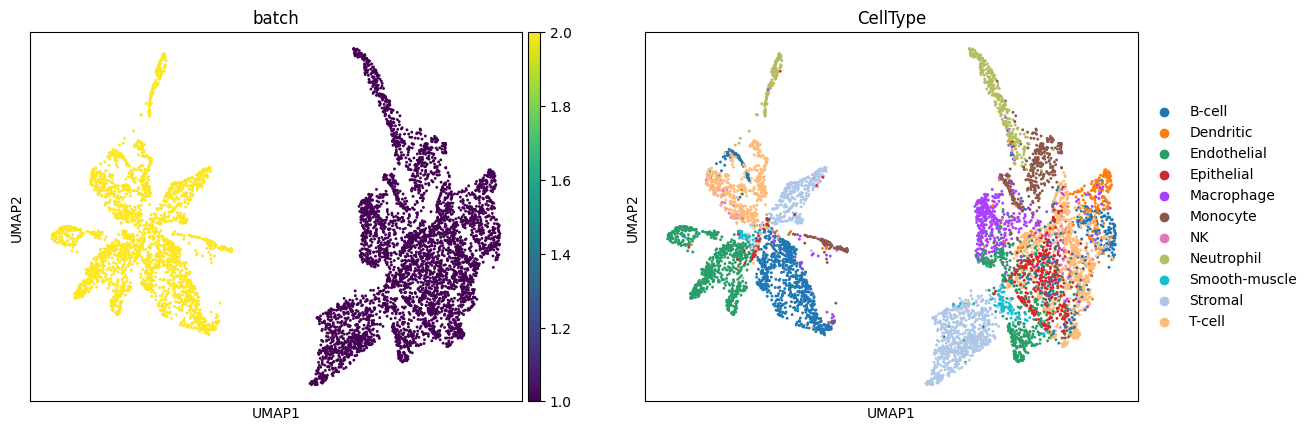

CPU times: total: 33.5 s
Wall time: 30 s


In [12]:
%%time

# Now, perform Harmony on the combined AnnData object instead of a single batch
combined_adata = adata_list[0].concatenate(adata_list[1:], batch_key=batch_label)

# Ensure PCA is already computed (if not, run PCA)
sc.tl.pca(combined_adata, svd_solver='arpack')

# Apply Harmony to the PCA coordinates (on combined data)
# Apply Harmony to the PCA coordinates (on combined data)
combined_adata.obsm['X_pca_harmony'] = harmonize(
    combined_adata.obsm['X_pca'],  # PCA embeddings
    combined_adata.obs,            
    batch_key=batch_label,        
    n_clusters=11,                
    max_iter_harmony=25,           
    max_iter_clustering=200,       
    tol_harmony=1e-5,              
    tol_clustering=1e-5,          
    ridge_lambda=2.0,           
    sigma=0.2,                     
    block_proportion=0.1,         
    theta=5.0,                    
    tau=0,                         
    correction_method='fast',     
    random_state=0,               
    use_gpu=False,            
    n_jobs=-1,               
    verbose=True                 
)

# Replace PCA coordinates with Harmony-corrected embeddings
combined_adata.obsm['X_pca'] = combined_adata.obsm['X_pca_harmony']

# Recompute neighbors and UMAP using Harmony-corrected data
sc.pp.neighbors(combined_adata, n_neighbors=30, n_pcs=40)
sc.tl.umap(combined_adata, spread=1.5)

# Plot UMAP with batch and cell type coloring
sc.pl.umap(combined_adata, color=['batch', 'CellType'], save="_harmony_umap.png")

In [11]:
%%time

# Embedding (Harmony-corrected PCA embeddings)
embedding = combined_adata.obsm['X_pca_harmony']  # Use Harmony embeddings (or UMAP/PCA)

# Convert embedding to DataFrame for alignment with metadata
embedding_df = pd.DataFrame(embedding, index=combined_adata.obs.index, columns=[f'PCA{i+1}' for i in range(50)])

# Ensure metadata is aligned and categorical columns are set properly
combined_adata.obs['batch'] = combined_adata.obs['batch'].astype('category')
combined_adata.obs['CellType'] = combined_adata.obs['CellType'].astype('category')

# Call the compute_lisi function for both "batch" and "celltype"
label_colnames = ["batch", "CellType"]
lisi_scores = compute_lisi(
    X=embedding,         # Harmony embeddings (cells x dimensions)
    metadata=combined_adata.obs,  # Metadata with batch/celltype info
    label_colnames=label_colnames    # Adjust based on your dataset size
)

# Separate LISI scores for each label
lisi_batch = lisi_scores[:, 0]  # LISI scores for "batch"
lisi_celltype = lisi_scores[:, 1]  # LISI scores for "celltype"

# Output the LISI results
print("Batch Mean LISI Scores:", lisi_batch.mean())
print("Batch Median LISI Scores:", np.median(lisi_batch))
print("Celltype Mean LISI Scores:", lisi_celltype.mean())
print("Celltype Median LISI Scores:", np.median(lisi_celltype))

batch_labels = combined_adata.obs['batch']
kbet_score = calculate_kbet(embedding[:, :2], batch_labels, k=20)  # Use the first 2 columns
print(f"kBET score: {kbet_score}")

# Add the cluster labels to the embedding dataframe
embedding_df['CellType'] = combined_adata.obs['CellType'].values  # Replace with the actual column name

# Now compute ASW for clusters
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='CellType')
print(f"ASW (CellType): {asw_cluster}")

# Add the batch labels (or clusters, cell types) to the embedding dataframe
embedding_df['batch'] = combined_adata.obs['batch'].values  # Adjust for the correct label column

# Now compute ASW for clusters or batches
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='batch')
print(f"ASW (Batch): {asw_cluster}")

Batch Mean LISI Scores: 1.015541748071914
Batch Median LISI Scores: 1.0
Celltype Mean LISI Scores: 1.3989948576151854
Celltype Median LISI Scores: 1.0960387109818388


<timed exec>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


kBET score: 0.9965415588150704
ASW (CellType): -0.4303169250488281
ASW (Batch): 0.37617650628089905
CPU times: total: 6.59 s
Wall time: 6.57 s


<timed exec>:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


	Initialization is completed.
	Completed 1 / 40 iteration(s).
	Completed 2 / 40 iteration(s).
	Completed 3 / 40 iteration(s).
Reach convergence after 3 iteration(s).


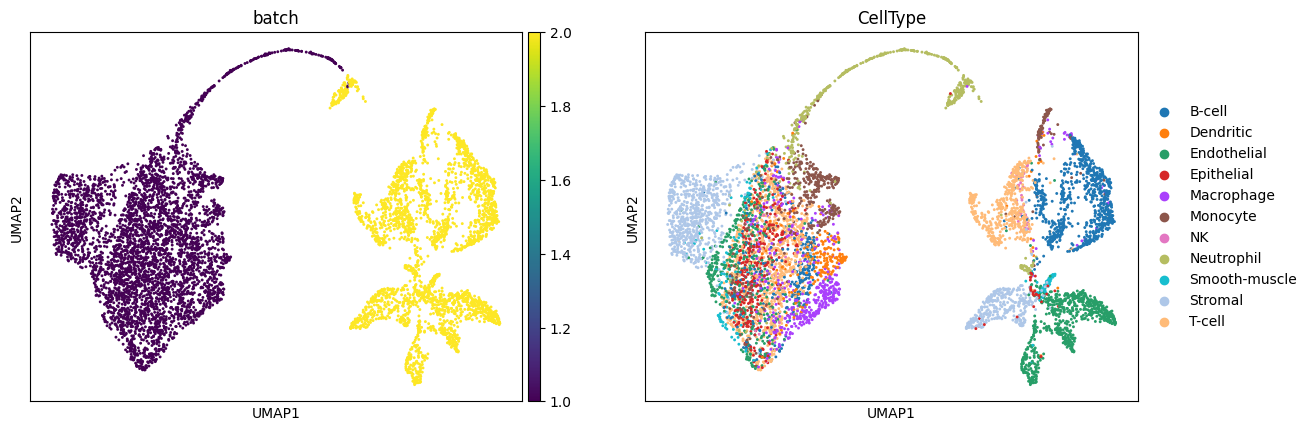

CPU times: total: 31.9 s
Wall time: 20.6 s


In [13]:
%%time

# Now, perform Harmony on the combined AnnData object instead of a single batch
combined_adata = adata_list[0].concatenate(adata_list[1:], batch_key=batch_label)

# Ensure PCA is already computed (if not, run PCA)
sc.tl.pca(combined_adata, svd_solver='arpack')

# Apply Harmony to the PCA coordinates (on combined data)
# Apply Harmony to the PCA coordinates (on combined data)
combined_adata.obsm['X_pca_harmony'] = harmonize(
    combined_adata.obsm['X_pca'],  # PCA embeddings
    combined_adata.obs,            
    batch_key=batch_label,        
    n_clusters=20,                
    max_iter_harmony=40,           
    max_iter_clustering=200,       
    tol_harmony=1e-5,              
    tol_clustering=1e-5,          
    ridge_lambda=1.0,           
    sigma=0.3,                     
    block_proportion=0.1,         
    theta=5.0,                    
    tau=0,                         
    correction_method='fast',     
    random_state=0,               
    use_gpu=False,            
    n_jobs=-1,               
    verbose=True                 
)

# Replace PCA coordinates with Harmony-corrected embeddings
combined_adata.obsm['X_pca'] = combined_adata.obsm['X_pca_harmony']

# Recompute neighbors and UMAP using Harmony-corrected data
sc.pp.neighbors(combined_adata, n_neighbors=30, n_pcs=40)
sc.tl.umap(combined_adata, spread=1.5)

# Plot UMAP with batch and cell type coloring
sc.pl.umap(combined_adata, color=['batch', 'CellType'], save="_harmony_umap.png")

In [14]:
%%time

# Embedding (Harmony-corrected PCA embeddings)
embedding = combined_adata.obsm['X_pca_harmony']  # Use Harmony embeddings (or UMAP/PCA)

# Convert embedding to DataFrame for alignment with metadata
embedding_df = pd.DataFrame(embedding, index=combined_adata.obs.index, columns=[f'PCA{i+1}' for i in range(50)])

# Ensure metadata is aligned and categorical columns are set properly
combined_adata.obs['batch'] = combined_adata.obs['batch'].astype('category')
combined_adata.obs['CellType'] = combined_adata.obs['CellType'].astype('category')

# Call the compute_lisi function for both "batch" and "celltype"
label_colnames = ["batch", "CellType"]
lisi_scores = compute_lisi(
    X=embedding,         # Harmony embeddings (cells x dimensions)
    metadata=combined_adata.obs,  # Metadata with batch/celltype info
    label_colnames=label_colnames    # Adjust based on your dataset size
)

# Separate LISI scores for each label
lisi_batch = lisi_scores[:, 0]  # LISI scores for "batch"
lisi_celltype = lisi_scores[:, 1]  # LISI scores for "celltype"

# Output the LISI results
print("Batch Mean LISI Scores:", lisi_batch.mean())
print("Batch Median LISI Scores:", np.median(lisi_batch))
print("Celltype Mean LISI Scores:", lisi_celltype.mean())
print("Celltype Median LISI Scores:", np.median(lisi_celltype))

batch_labels = combined_adata.obs['batch']
kbet_score = calculate_kbet(embedding[:, :2], batch_labels, k=20)  # Use the first 2 columns
print(f"kBET score: {kbet_score}")

# Add the cluster labels to the embedding dataframe
embedding_df['CellType'] = combined_adata.obs['CellType'].values  # Replace with the actual column name

# Now compute ASW for clusters
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='CellType')
print(f"ASW (CellType): {asw_cluster}")

# Add the batch labels (or clusters, cell types) to the embedding dataframe
embedding_df['batch'] = combined_adata.obs['batch'].values  # Adjust for the correct label column

# Now compute ASW for clusters or batches
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='batch')
print(f"ASW (Batch): {asw_cluster}")

Batch Mean LISI Scores: 1.0063851785901685
Batch Median LISI Scores: 1.0
Celltype Mean LISI Scores: 1.553066226553693
Celltype Median LISI Scores: 1.2016228744488586


<timed exec>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


kBET score: 0.9919327006039689
ASW (CellType): -0.44384217262268066
ASW (Batch): 0.4552712142467499
CPU times: total: 6.23 s
Wall time: 6.26 s


<timed exec>:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


	Initialization is completed.
	Completed 1 / 40 iteration(s).
	Completed 2 / 40 iteration(s).
	Completed 3 / 40 iteration(s).
	Completed 4 / 40 iteration(s).
Reach convergence after 4 iteration(s).


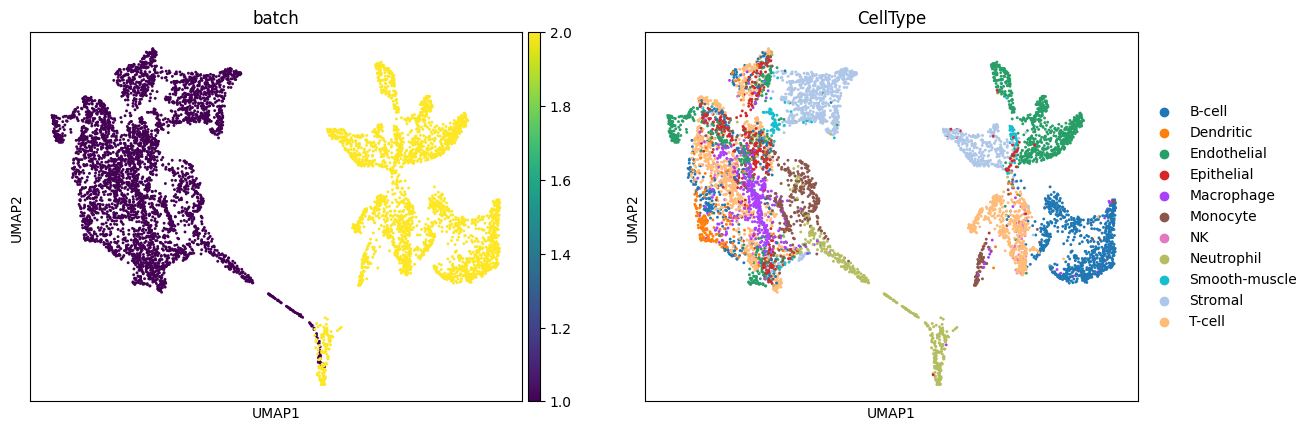

CPU times: total: 28.8 s
Wall time: 20.3 s


In [14]:
%%time

# Now, perform Harmony on the combined AnnData object instead of a single batch
combined_adata = adata_list[0].concatenate(adata_list[1:], batch_key=batch_label)

# Ensure PCA is already computed (if not, run PCA)
sc.tl.pca(combined_adata, svd_solver='arpack')

# Apply Harmony to the PCA coordinates (on combined data)
# Apply Harmony to the PCA coordinates (on combined data)
combined_adata.obsm['X_pca_harmony'] = harmonize(
    combined_adata.obsm['X_pca'],  # PCA embeddings
    combined_adata.obs,            
    batch_key=batch_label,        
    n_clusters=20,                
    max_iter_harmony=40,           
    max_iter_clustering=200,       
    tol_harmony=1e-6,              
    tol_clustering=1e-5,          
    ridge_lambda=1.0,           
    sigma=0.3,                     
    block_proportion=0.15,         
    theta=5.0,                    
    tau=0,                         
    correction_method='original',     
    random_state=42,               
    use_gpu=False,            
    n_jobs=-1,               
    verbose=True                 
)

# Replace PCA coordinates with Harmony-corrected embeddings
combined_adata.obsm['X_pca'] = combined_adata.obsm['X_pca_harmony']

# Recompute neighbors and UMAP using Harmony-corrected data
sc.pp.neighbors(combined_adata, n_neighbors=30, n_pcs=40)
sc.tl.umap(combined_adata, spread=1.5)

# Plot UMAP with batch and cell type coloring
sc.pl.umap(combined_adata, color=['batch', 'CellType'], save="_harmony_umap.png")

In [16]:
%%time

# Embedding (Harmony-corrected PCA embeddings)
embedding = combined_adata.obsm['X_pca_harmony']  # Use Harmony embeddings (or UMAP/PCA)

# Convert embedding to DataFrame for alignment with metadata
embedding_df = pd.DataFrame(embedding, index=combined_adata.obs.index, columns=[f'PCA{i+1}' for i in range(50)])

# Ensure metadata is aligned and categorical columns are set properly
combined_adata.obs['batch'] = combined_adata.obs['batch'].astype('category')
combined_adata.obs['CellType'] = combined_adata.obs['CellType'].astype('category')

# Call the compute_lisi function for both "batch" and "celltype"
label_colnames = ["batch", "CellType"]
lisi_scores = compute_lisi(
    X=embedding,         # Harmony embeddings (cells x dimensions)
    metadata=combined_adata.obs,  # Metadata with batch/celltype info
    label_colnames=label_colnames    # Adjust based on your dataset size
)

# Separate LISI scores for each label
lisi_batch = lisi_scores[:, 0]  # LISI scores for "batch"
lisi_celltype = lisi_scores[:, 1]  # LISI scores for "celltype"

# Output the LISI results
print("Batch Mean LISI Scores:", lisi_batch.mean())
print("Batch Median LISI Scores:", np.median(lisi_batch))
print("Celltype Mean LISI Scores:", lisi_celltype.mean())
print("Celltype Median LISI Scores:", np.median(lisi_celltype))

batch_labels = combined_adata.obs['batch']
kbet_score = calculate_kbet(embedding[:, :2], batch_labels, k=20)  # Use the first 2 columns
print(f"kBET score: {kbet_score}")

# Add the cluster labels to the embedding dataframe
embedding_df['CellType'] = combined_adata.obs['CellType'].values  # Replace with the actual column name

# Now compute ASW for clusters
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='CellType')
print(f"ASW (CellType): {asw_cluster}")

# Add the batch labels (or clusters, cell types) to the embedding dataframe
embedding_df['batch'] = combined_adata.obs['batch'].values  # Adjust for the correct label column

# Now compute ASW for clusters or batches
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='batch')
print(f"ASW (Batch): {asw_cluster}")

Batch Mean LISI Scores: 1.0112865989923934
Batch Median LISI Scores: 1.0
Celltype Mean LISI Scores: 1.5051787386444382
Celltype Median LISI Scores: 1.1551108250972852


<timed exec>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


kBET score: 0.9897900488927236
ASW (CellType): -0.429413378238678
ASW (Batch): 0.44798824191093445
CPU times: total: 6.45 s
Wall time: 6.44 s


<timed exec>:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


	Initialization is completed.
	Completed 1 / 40 iteration(s).
Reach convergence after 1 iteration(s).


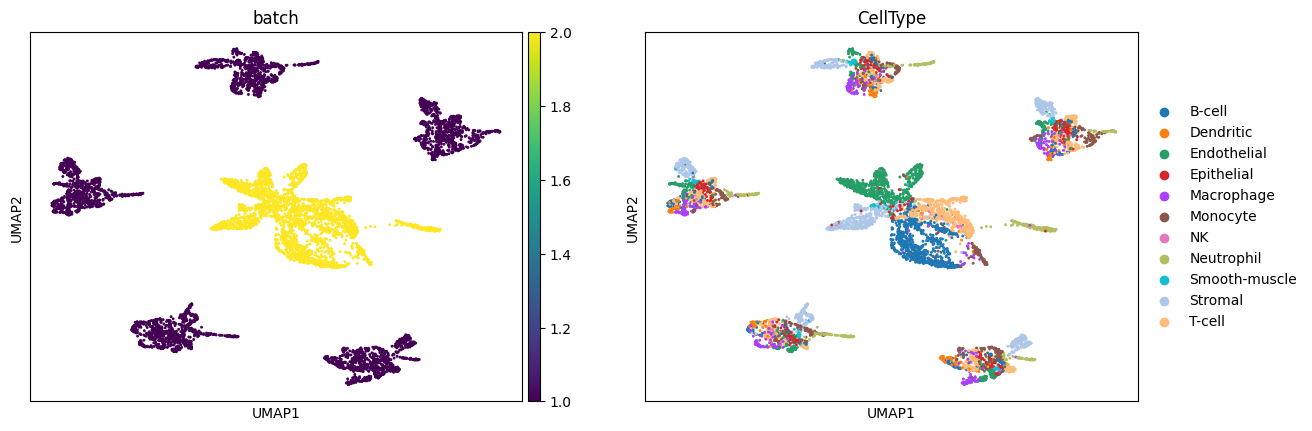

CPU times: total: 29.1 s
Wall time: 18.3 s


In [15]:
%%time

# Now, perform Harmony on the combined AnnData object instead of a single batch
combined_adata = adata_list[0].concatenate(adata_list[1:], batch_key=batch_label)

# Ensure PCA is already computed (if not, run PCA)
sc.tl.pca(combined_adata, svd_solver='arpack')

# Apply Harmony to the PCA coordinates (on combined data)
# Apply Harmony to the PCA coordinates (on combined data)
combined_adata.obsm['X_pca_harmony'] = harmonize(
    combined_adata.obsm['X_pca'],  # PCA embeddings
    combined_adata.obs,            
    batch_key=batch_label,        
    n_clusters=30,                
    max_iter_harmony=40,           
    max_iter_clustering=300,       
    tol_harmony=1e-7,              
    tol_clustering=1e-6,          
    ridge_lambda=0.5,           
    sigma=0.3,                     
    block_proportion=0.2,         
    theta=10.0,                    
    tau=0,                         
    correction_method='original',     
    random_state=42,               
    use_gpu=False,            
    n_jobs=-1,               
    verbose=True                 
)

# Replace PCA coordinates with Harmony-corrected embeddings
combined_adata.obsm['X_pca'] = combined_adata.obsm['X_pca_harmony']

# Recompute neighbors and UMAP using Harmony-corrected data
sc.pp.neighbors(combined_adata, n_neighbors=30, n_pcs=40)
sc.tl.umap(combined_adata, spread=1.5)

# Plot UMAP with batch and cell type coloring
sc.pl.umap(combined_adata, color=['batch', 'CellType'], save="_harmony_umap.png")

In [18]:
%%time

# Embedding (Harmony-corrected PCA embeddings)
embedding = combined_adata.obsm['X_pca_harmony']  # Use Harmony embeddings (or UMAP/PCA)

# Convert embedding to DataFrame for alignment with metadata
embedding_df = pd.DataFrame(embedding, index=combined_adata.obs.index, columns=[f'PCA{i+1}' for i in range(50)])

# Ensure metadata is aligned and categorical columns are set properly
combined_adata.obs['batch'] = combined_adata.obs['batch'].astype('category')
combined_adata.obs['CellType'] = combined_adata.obs['CellType'].astype('category')

# Call the compute_lisi function for both "batch" and "celltype"
label_colnames = ["batch", "CellType"]
lisi_scores = compute_lisi(
    X=embedding,         # Harmony embeddings (cells x dimensions)
    metadata=combined_adata.obs,  # Metadata with batch/celltype info
    label_colnames=label_colnames    # Adjust based on your dataset size
)

# Separate LISI scores for each label
lisi_batch = lisi_scores[:, 0]  # LISI scores for "batch"
lisi_celltype = lisi_scores[:, 1]  # LISI scores for "celltype"

# Output the LISI results
print("Batch Mean LISI Scores:", lisi_batch.mean())
print("Batch Median LISI Scores:", np.median(lisi_batch))
print("Celltype Mean LISI Scores:", lisi_celltype.mean())
print("Celltype Median LISI Scores:", np.median(lisi_celltype))

batch_labels = combined_adata.obs['batch']
kbet_score = calculate_kbet(embedding[:, :2], batch_labels, k=20)  # Use the first 2 columns
print(f"kBET score: {kbet_score}")

# Add the cluster labels to the embedding dataframe
embedding_df['CellType'] = combined_adata.obs['CellType'].values  # Replace with the actual column name

# Now compute ASW for clusters
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='CellType')
print(f"ASW (CellType): {asw_cluster}")

# Add the batch labels (or clusters, cell types) to the embedding dataframe
embedding_df['batch'] = combined_adata.obs['batch'].values  # Adjust for the correct label column

# Now compute ASW for clusters or batches
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='batch')
print(f"ASW (Batch): {asw_cluster}")

Batch Mean LISI Scores: 1.005519104259786
Batch Median LISI Scores: 1.0
Celltype Mean LISI Scores: 1.5603432967895592
Celltype Median LISI Scores: 1.2267894876967105


<timed exec>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


kBET score: 0.994197584124245
ASW (CellType): -0.33887800574302673
ASW (Batch): 0.37474721670150757
CPU times: total: 5.53 s
Wall time: 6.1 s


## Pycombat

In [63]:
%%time

# Step 1: Generate the batch list
batch_label = 'batch'
celltype_label = 'CellType'
datasets = []
batch = []
mod = []

for batch_index, batch_value in enumerate(metadata[batch_label].unique()):
    batch_cells = metadata[metadata[batch_label] == batch_value].index
    datasets.append(expr_mat.loc[:, batch_cells])
    batch.extend([batch_index] * len(batch_cells))
    
    # Add the corresponding cell types for the batch cells
    celltypes_for_batch = metadata.loc[batch_cells, celltype_label].values
    mod.extend(celltypes_for_batch)  # Collect cell type information as a covariate

# Concatenate all datasets by keeping only the common genes (inner join)
df_expression = pd.concat(datasets, axis=1, join="inner")

df_corrected = pycombat(df_expression, batch)

# Step 2: Apply pycombat with cell type as a covariate
# df_corrected = pycombat(df_expression, batch, mod=mod, precision=0.001)

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\combat\pycombat.py:159: RuntimeWarning: divide by zero encountered in divide


Adjusting the Data
CPU times: total: 25 s
Wall time: 17 s


In [64]:
%%time

def calculate_kbet(embedding, labels, k=20):
    """
    Calculate the kBET score for batch correction.
    
    Parameters:
    - embedding: np.array, shape (n_cells, n_dimensions), t-SNE or UMAP embedding.
    - labels: list or np.array or pd.Series, cell labels (e.g., batch labels).
    - k: int, the number of nearest neighbors to consider.
    
    Returns:
    - kBET score: float, the proportion of neighbors from the same batch.
    """
    # Transpose the data if needed
    if embedding.shape[0] != len(labels):
        embedding = embedding.T
    
    # Ensure labels is a pandas Series
    if not isinstance(labels, pd.Series):
        labels = pd.Series(labels)
    
    # Validate input shapes
    if len(labels) != embedding.shape[0]:
        raise ValueError(f"Number of labels ({len(labels)}) does not match number of embedding rows ({embedding.shape[0]})")
    
    # Fit Nearest Neighbors
    nn = NearestNeighbors(n_neighbors=k+1)  # +1 to exclude self
    nn.fit(embedding)
    
    # Find k-nearest neighbors for each cell
    neighbors = nn.kneighbors(embedding, return_distance=False)
    
    # Count how many neighbors belong to the same batch
    kbet_scores = []
    for i, cell_neighbors in enumerate(neighbors):
        # Exclude self from neighbors
        cell_neighbors = cell_neighbors[1:]
        
        # Extract batch labels of the nearest neighbors
        neighbor_labels = labels.iloc[cell_neighbors]
        
        # Calculate the proportion of neighbors from the same batch
        same_batch_proportion = np.sum(neighbor_labels == labels.iloc[i]) / k
        kbet_scores.append(same_batch_proportion)
    
    # kBET score: the mean proportion of neighbors from the same batch
    kbet_score = np.mean(kbet_scores)
    return kbet_score


CPU times: total: 0 ns
Wall time: 15.7 ms


In [66]:
%%time

def calculate_asw(data, embeddings_columns, labels_column):
    """
    Calculate Average Silhouette Width (ASW).
    
    Parameters:
        data (pd.DataFrame): DataFrame containing embeddings and labels.
        embeddings_columns (list): List of columns for the embedding coordinates.
        labels_column (str): Column name for the labels (e.g., 'Cluster' or 'Dataset').
    
    Returns:
        float: ASW score.
    """
    # Transpose the data to get cells as rows
    embeddings = data[embeddings_columns].values.T
    
    # Validate labels
    labels = pd.Series(labels_column) if isinstance(labels_column, (list, np.ndarray)) else data[labels_column]
    
    # Check if lengths match after transposing
    if len(labels) != embeddings.shape[1]:
        raise ValueError(f"Number of labels ({len(labels)}) does not match number of embedding rows ({embeddings.shape[1]})")
    
    # Calculate silhouette score
    asw_score = silhouette_score(embeddings, labels)
    return asw_score

CPU times: total: 0 ns
Wall time: 0 ns


In [68]:
%%time

# Assuming df_corrected is your corrected data matrix (cells x genes)
tsne = TSNE(n_components=2, random_state=42)
embedding = tsne.fit_transform(df_corrected.T)  # Transpose if needed (cells x genes -> genes x cells)

# Calculate kBET score
kbet_score = calculate_kbet(embedding, batch)
print(f"kBET Score: {kbet_score}")

# Convert to DataFrame for alignment with metadata
embedding_df = pd.DataFrame(embedding, index=metadata.index, columns=['UMAP1', 'UMAP2'])

# Ensure that the 'batch' and 'CellType' are in the metadata and aligned with embedding_df
embedding_df['batch'] = metadata['batch']
embedding_df['CellType'] = metadata['CellType']

# Example call to compute LISI for both batch and cell type
label_colnames = ["batch", "CellType"]  # Modify as per your metadata
lisi_scores = compute_lisi(
    X=embedding_df[['UMAP1', 'UMAP2']],  # Using the embedding columns
    metadata=embedding_df,  # DataFrame with batch/celltype information
    label_colnames=label_colnames,
    perplexity=30           # Adjust perplexity based on dataset size
)

# Separate LISI scores for each label
lisi_batch = lisi_scores[:, 0]  # LISI scores for "batch"
lisi_celltype = lisi_scores[:, 1]  # LISI scores for "celltype"

# Output the LISI results
print("Batch Mean LISI Scores:", lisi_batch.mean())
print("Batch Median LISI Scores:", np.median(lisi_batch))
print("Celltype Mean LISI Scores:", lisi_celltype.mean())
print("Celltype Median LISI Scores:", np.median(lisi_celltype))

# ASW Calculation Function
def calculate_asw(data, embeddings_columns, labels_column):
    """
    Calculate Average Silhouette Width (ASW).
    
    Parameters:
        data (pd.DataFrame): DataFrame containing embeddings and labels.
        embeddings_columns (list): List of columns for the embedding coordinates.
        labels_column (str): Column name for the labels (e.g., 'Cluster' or 'Dataset').
    
    Returns:
        float: ASW score.
    """
    # Extract embeddings
    embeddings = data[embeddings_columns].values
    
    # Validate labels
    labels = data[labels_column]  # Directly access the labels from the DataFrame
    
    # Check if lengths match
    if len(labels) != embeddings.shape[0]:
        raise ValueError(f"Number of labels ({len(labels)}) does not match number of embedding rows ({embeddings.shape[0]})")
    
    # Calculate silhouette score (ASW)
    asw_score = silhouette_score(embeddings, labels)
    return asw_score

# Calculate ASW for both "batch" and "CellType"
batch_asw = calculate_asw(embedding_df, ['UMAP1', 'UMAP2'], 'batch')
celltype_asw = calculate_asw(embedding_df, ['UMAP1', 'UMAP2'], 'CellType')

# Print ASW scores
print(f"Batch ASW Score: {batch_asw}")
print(f"Celltype ASW Score: {celltype_asw}")

kBET Score: 0.9943270060396894
Batch Mean LISI Scores: 1.0065107407245213
Batch Median LISI Scores: 1.0
Celltype Mean LISI Scores: 1.4354817783671598
Celltype Median LISI Scores: 1.0511678366869444
Batch ASW Score: 0.38075342774391174
Celltype ASW Score: 0.005462089087814093
CPU times: total: 59.5 s
Wall time: 31.8 s
